In [1]:
pip install -q PyPDF2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer
from datasets import Dataset
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainerCallback
import warnings
warnings.filterwarnings("ignore", message="A parameter name that contains beta will be renamed internally to bias")


In [3]:
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
df.shape

(2484, 4)

(array([], dtype=float64), [])

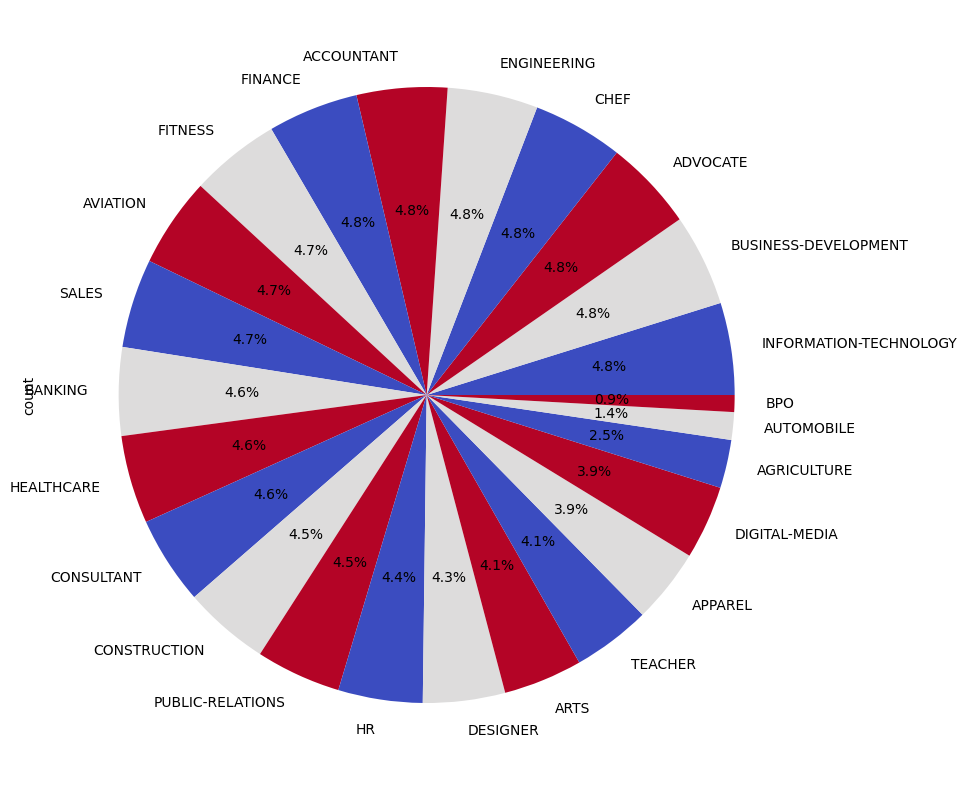

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,10))
df['Category'].value_counts().plot(kind='pie',autopct='%1.1f%%',colors=plt.cm.coolwarm(np.linspace(0,1,3)))
plt.xticks(rotation=90)

In [6]:
df['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

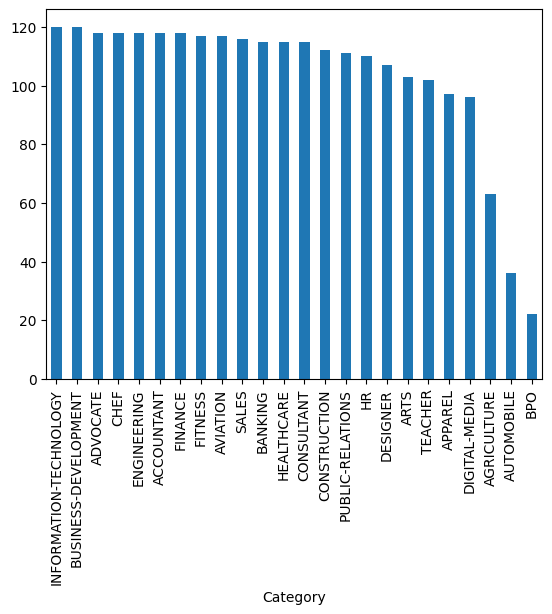

In [7]:
df['Category'].value_counts().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

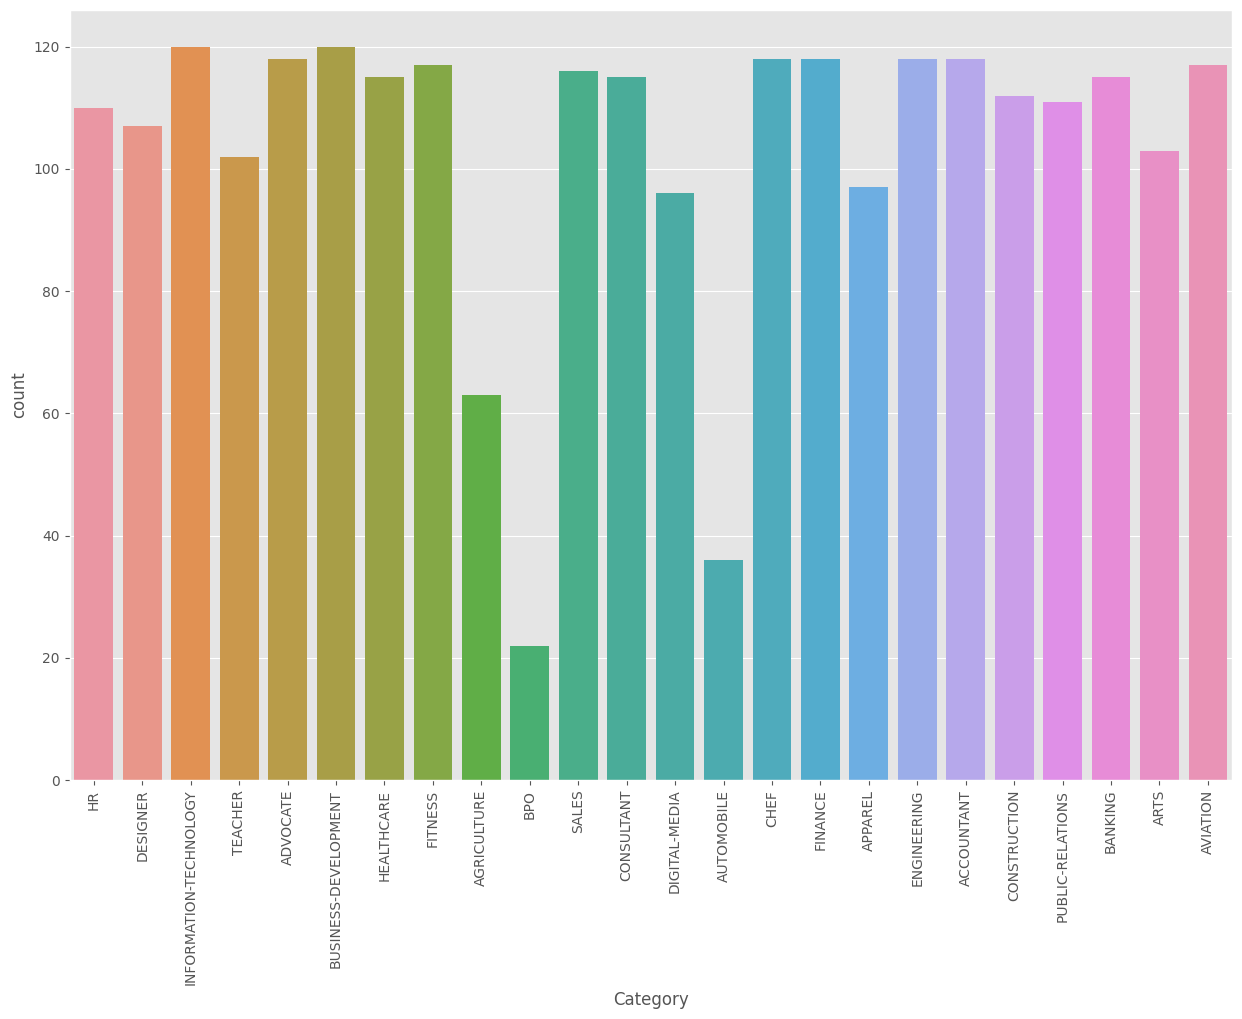

In [8]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
sns.countplot(x=df['Category'])
plt.xticks(rotation=90)
plt.show()

In [9]:
import re

def clean(text):

    cleanText = re.sub('http\S+\s', ' ', text)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+\s', ' ', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)  
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./\:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText) 
    cleanText = re.sub('\s+', ' ', cleanText)
    cleanText = re.sub(' \n ', ' ',cleanText)
    cleanText = re.sub(' \\\/// ', ' ',cleanText)
    return cleanText

In [10]:
clean('HI my name is > vinayak\ /// bhatia and @my //website is http://ali')

'HI my name is vinayak bhatia and website is http ali'

In [16]:
# Load the dataset
data = pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")

# Check for missing values and data info
print(data.isnull().sum())
print(data.info())


ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB
None


In [17]:
# Combine categories into 6 groups as per your requirement
combined_categories = {
    'TECH': ['INFORMATION-TECHNOLOGY', 'ENGINEERING', 'DIGITAL-MEDIA'],
    'NON-TECH': ['HR', 'SALES', 'CONSULTANT', 'PUBLIC-RELATIONS'],
    'MEDICAL': ['HEALTHCARE', 'FITNESS'],
    'LEGAL': ['ADVOCATE'],
    'EDUCATION': ['TEACHER'],
    'OTHERS': ['AGRICULTURE', 'BPO', 'AUTOMOBILE', 'CHEF', 'FINANCE', 
               'APPAREL', 'ACCOUNTANT', 'CONSTRUCTION', 'BANKING', 
               'ARTS', 'AVIATION', 'DESIGNER', 'BUSINESS-DEVELOPMENT']
}

def map_to_combined_category(category):
    for key, values in combined_categories.items():
        if category in values:
            return key
    return 'OTHERS'

data['Combined_Category'] = data['Category'].apply(map_to_combined_category)
data['Combined_Category'].value_counts()


Combined_Category
OTHERS       1246
NON-TECH      452
TECH          334
MEDICAL       232
LEGAL         118
EDUCATION     102
Name: count, dtype: int64

In [18]:
data['label'] = data['Combined_Category'].astype('category').cat.codes
label_mapping = dict(enumerate(data['Combined_Category'].astype('category').cat.categories))
print("Label Mapping:", label_mapping)


Label Mapping: {0: 'EDUCATION', 1: 'LEGAL', 2: 'MEDICAL', 3: 'NON-TECH', 4: 'OTHERS', 5: 'TECH'}


In [19]:
df = data.drop(columns=["Resume_html", "Category"]).rename(columns={"Resume_str": "Resume"})
df.head()

,ID,Resume,Combined_Category,label
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,NON-TECH,3
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",NON-TECH,3
2,33176873,HR DIRECTOR Summary Over 2...,NON-TECH,3
3,27018550,HR SPECIALIST Summary Dedica...,NON-TECH,3
4,17812897,HR MANAGER Skill Highlights ...,NON-TECH,3


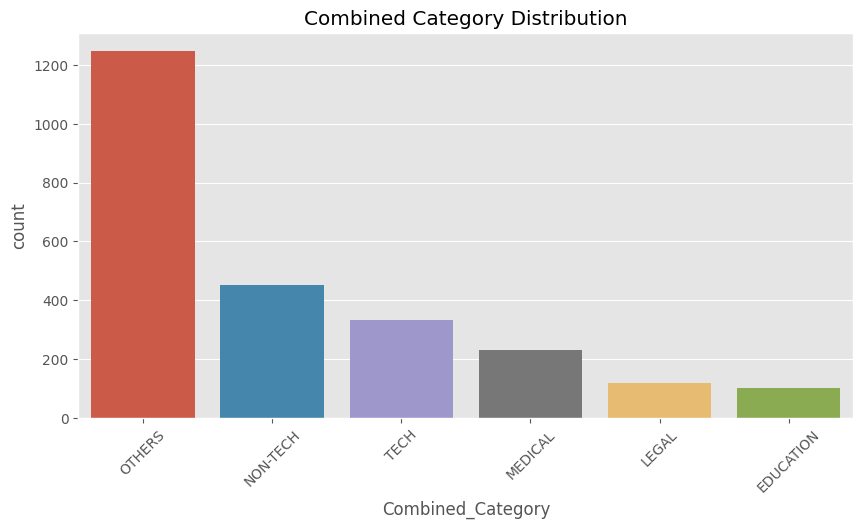

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Combined_Category'], order=df['Combined_Category'].value_counts().index)
plt.title('Combined Category Distribution')
plt.xticks(rotation=45)
plt.show()

In [21]:
train, temp = train_test_split(df, test_size=0.3, stratify=df['label'])
val, test = train_test_split(temp, test_size=0.3, stratify=temp['label'])
print("Train shape:", train.shape, "Validation shape:", val.shape, "Test shape:", test.shape)

Train shape: (1738, 4) Validation shape: (522, 4) Test shape: (224, 4)


In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define a function to tokenize resumes
def tokenize_function(examples):
    return tokenizer(examples["Resume"], padding="max_length", truncation=True, max_length=512)


In [ ]:
# Convert dataframes to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set dataset format
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_mapping)
)


In [25]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [29]:
training_args = TrainingArguments(
    output_dir="./combined_category_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    save_strategy="epoch",
)


In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [31]:
trainer.train()
trainer.save_model("./combined_category_model")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.686400,0.584016,0.823755,0.842830,0.823755,0.810959
2,0.436900,0.354201,0.898467,0.901753,0.898467,0.898160
3,0.238000,0.318503,0.917625,0.919798,0.917625,0.917764
4,0.167300,0.348037,0.911877,0.915233,0.911877,0.912431
5,0.093400,0.342975,0.915709,0.917801,0.915709,0.916101


In [32]:
metrics = trainer.evaluate(test_dataset)
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'eval_loss': 0.5430150032043457, 'eval_accuracy': 0.8839285714285714, 'eval_precision': 0.8845144620226856, 'eval_recall': 0.8839285714285714, 'eval_f1': 0.8834592852763846, 'eval_runtime': 3.473, 'eval_samples_per_second': 64.498, 'eval_steps_per_second': 4.031, 'epoch': 5.0}


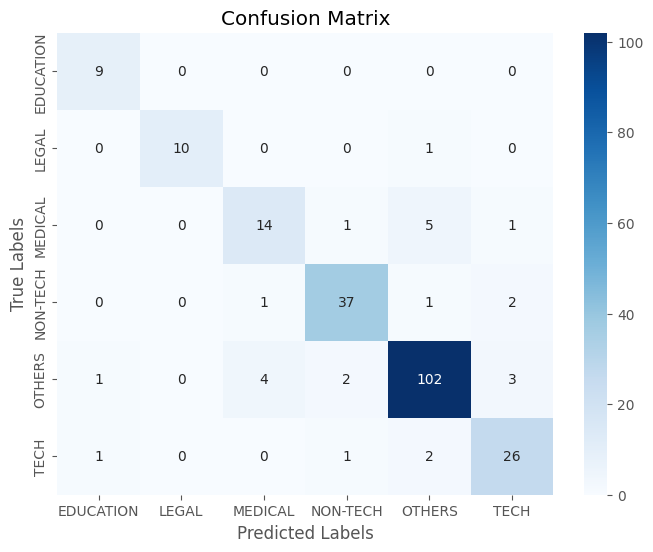

In [33]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [34]:
print(labels)

[4 4 5 4 4 0 5 2 4 4 3 4 4 5 4 4 2 5 4 4 0 2 4 4 4 4 4 5 4 0 4 3 4 4 4 2 5
 4 1 5 4 4 3 0 5 4 5 4 3 4 2 4 2 4 3 4 4 3 4 3 4 4 4 4 3 3 4 3 0 4 3 4 3 4
 5 5 4 4 5 2 1 4 3 3 4 3 4 3 4 4 4 3 5 4 4 4 4 4 3 4 4 4 4 5 4 5 4 5 4 2 4
 2 4 4 4 1 4 3 3 5 3 4 4 4 4 3 2 1 4 2 4 4 2 4 4 3 3 5 4 0 5 3 4 4 5 2 3 5
 5 5 4 1 4 4 1 5 5 1 2 3 3 4 2 3 0 2 4 4 3 3 4 2 3 4 4 4 3 1 3 5 4 0 3 3 1
 5 3 4 4 5 4 1 5 4 4 5 4 4 4 4 4 2 4 4 4 2 4 0 4 4 4 2 3 3 4 3 4 4 1 4 2 4
 4 3]


In [35]:
test_df_with_predictions = test.copy()
test_df_with_predictions['Predicted_Label'] = preds
test_df_with_predictions['Actual_Label'] = labels

# Map label indices to their corresponding category names (assuming label_mapping is available)
test_df_with_predictions['Predicted_Category'] = test_df_with_predictions['Predicted_Label'].map(lambda x: label_mapping.get(x))
test_df_with_predictions['Actual_Category'] = test_df_with_predictions['Actual_Label'].map(lambda x: label_mapping.get(x))

# Display the first few rows to compare actual vs predicted
print(test_df_with_predictions[['Actual_Category', 'Predicted_Category']])

     Actual_Category Predicted_Category
975           OTHERS             OTHERS
602           OTHERS             OTHERS
1708            TECH               TECH
1593          OTHERS             OTHERS
1360          OTHERS             OTHERS
...              ...                ...
609           OTHERS             OTHERS
869          MEDICAL            MEDICAL
1931          OTHERS             OTHERS
178           OTHERS             OTHERS
1102        NON-TECH           NON-TECH

[224 rows x 2 columns]


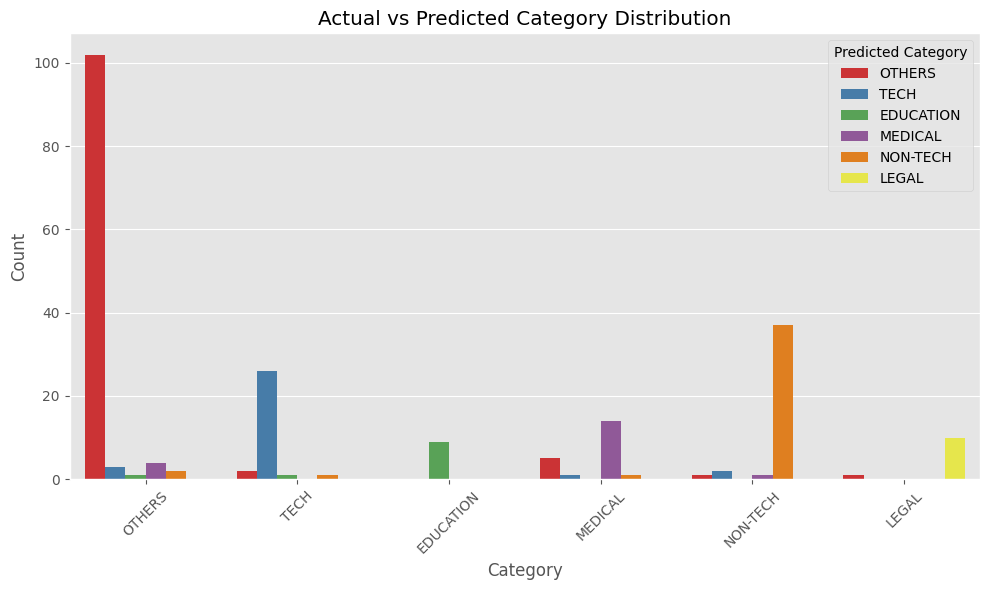

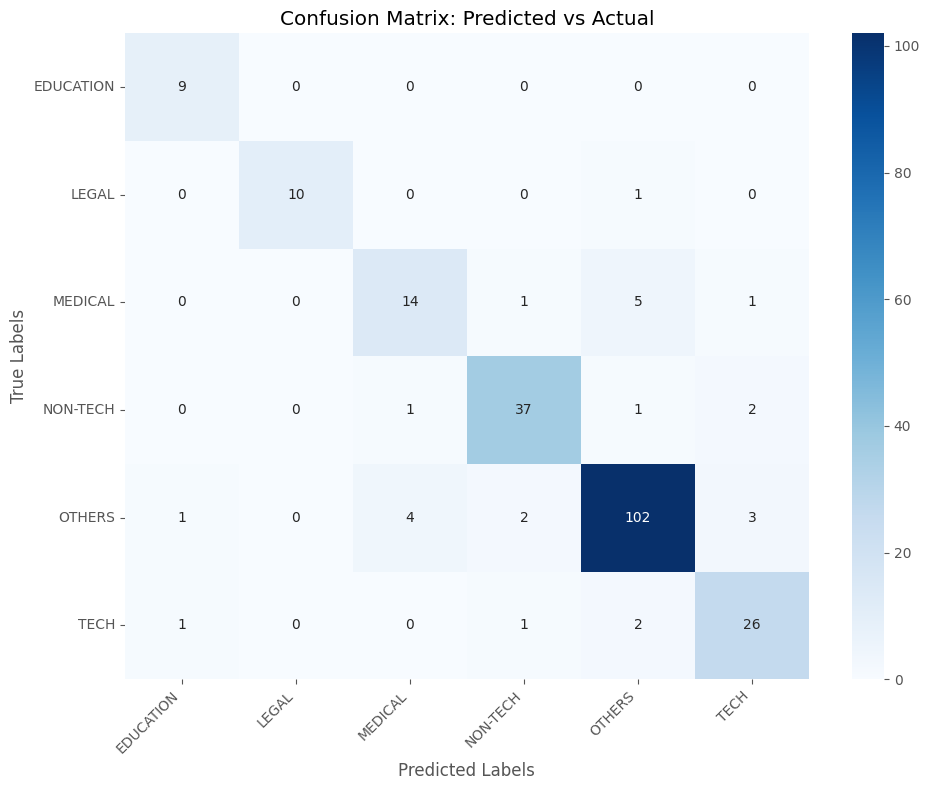


Classification Report:

              precision    recall  f1-score   support

   EDUCATION       0.82      1.00      0.90         9
       LEGAL       1.00      0.91      0.95        11
     MEDICAL       0.74      0.67      0.70        21
    NON-TECH       0.90      0.90      0.90        41
      OTHERS       0.92      0.91      0.91       112
        TECH       0.81      0.87      0.84        30

    accuracy                           0.88       224
   macro avg       0.86      0.88      0.87       224
weighted avg       0.88      0.88      0.88       224



In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(data=test_df_with_predictions, x='Actual_Category', hue='Predicted_Category', palette='Set1')
plt.title("Actual vs Predicted Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Predicted Category")
plt.tight_layout()
plt.show()

# 2. Confusion Matrix Visualization
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Predicted vs Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Classification Report (optional, as text)
print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=label_mapping.values()))

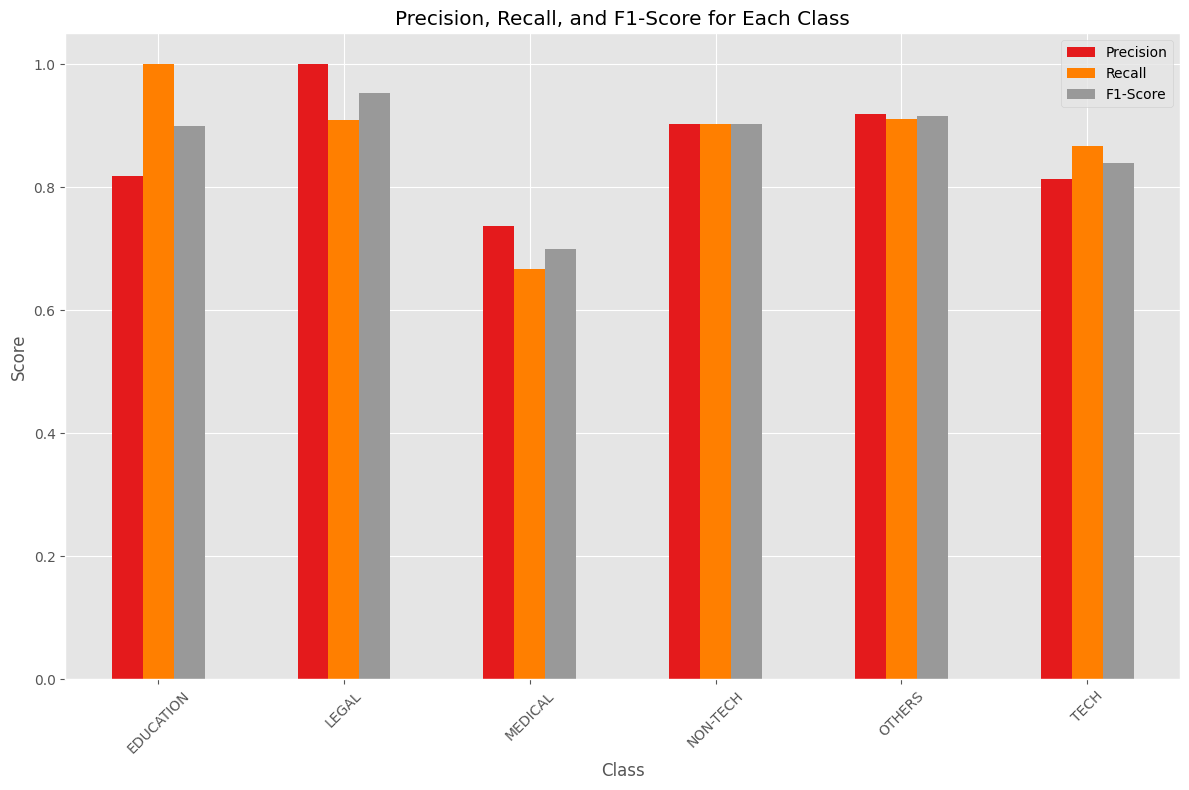

In [37]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, and f1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)

# Create a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Class': label_mapping.values(),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Plot Precision, Recall, and F1-Score for each class
metrics_df.set_index('Class').plot(kind='bar', figsize=(12, 8), colormap='Set1')
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


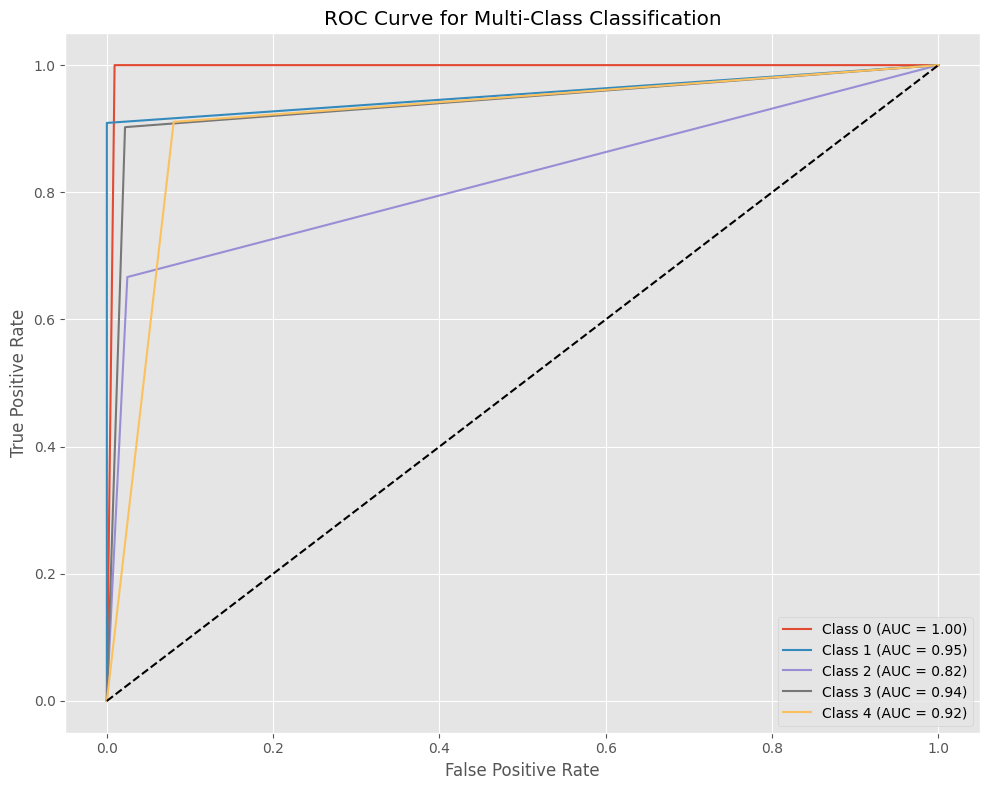

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC curve (if needed)
labels_bin = label_binarize(labels, classes=[0, 1, 2, 3, 4])  # Adjust based on your number of classes
preds_bin = label_binarize(preds, classes=[0, 1, 2, 3, 4])  # Adjust based on your number of classes

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(labels_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(labels_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve for Multi-Class Classification")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


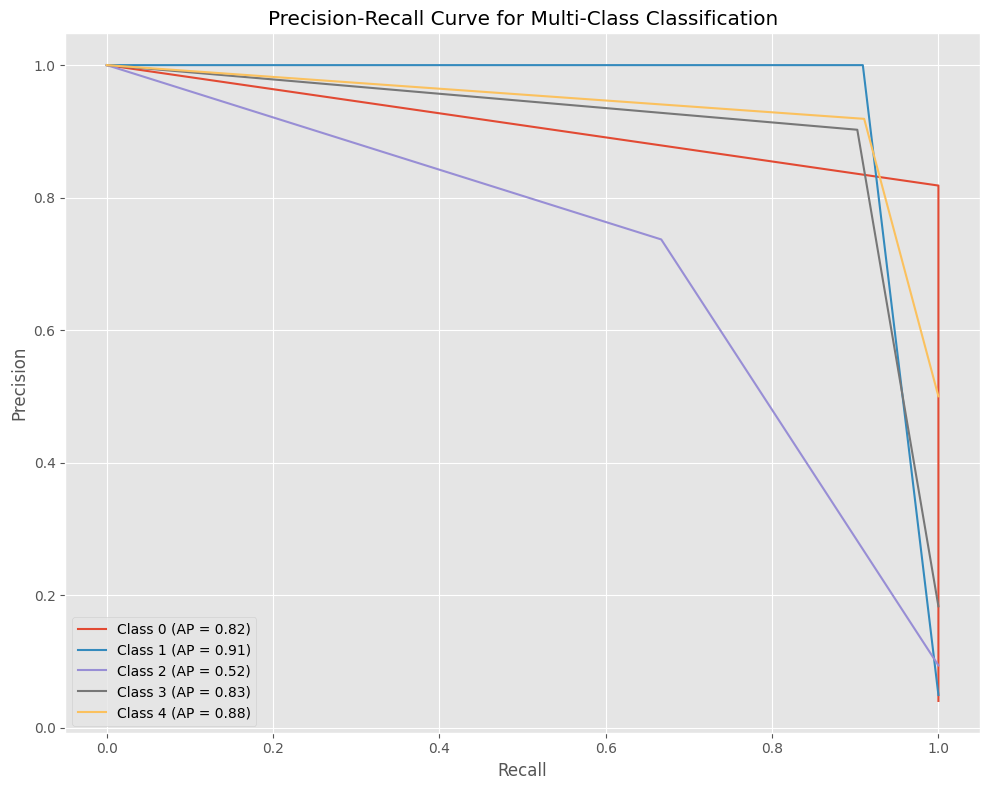

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Calculate Precision-Recall curve for each class
precisions, recalls, _ = {}, {}, {}
average_precisions = {}

for i in range(labels_bin.shape[1]):
    precisions[i], recalls[i], _ = precision_recall_curve(labels_bin[:, i], preds_bin[:, i])
    average_precisions[i] = average_precision_score(labels_bin[:, i], preds_bin[:, i])

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
for i in range(labels_bin.shape[1]):
    plt.plot(recalls[i], precisions[i], label=f'Class {i} (AP = {average_precisions[i]:.2f})')

plt.title("Precision-Recall Curve for Multi-Class Classification")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


     Actual_Category Predicted_Category
2303          OTHERS            MEDICAL
2229          OTHERS            MEDICAL
1246            TECH           NON-TECH
1213        NON-TECH             OTHERS
748          MEDICAL               TECH
881          MEDICAL             OTHERS
1606          OTHERS          EDUCATION
2028          OTHERS            MEDICAL
879          MEDICAL             OTHERS
547            LEGAL             OTHERS


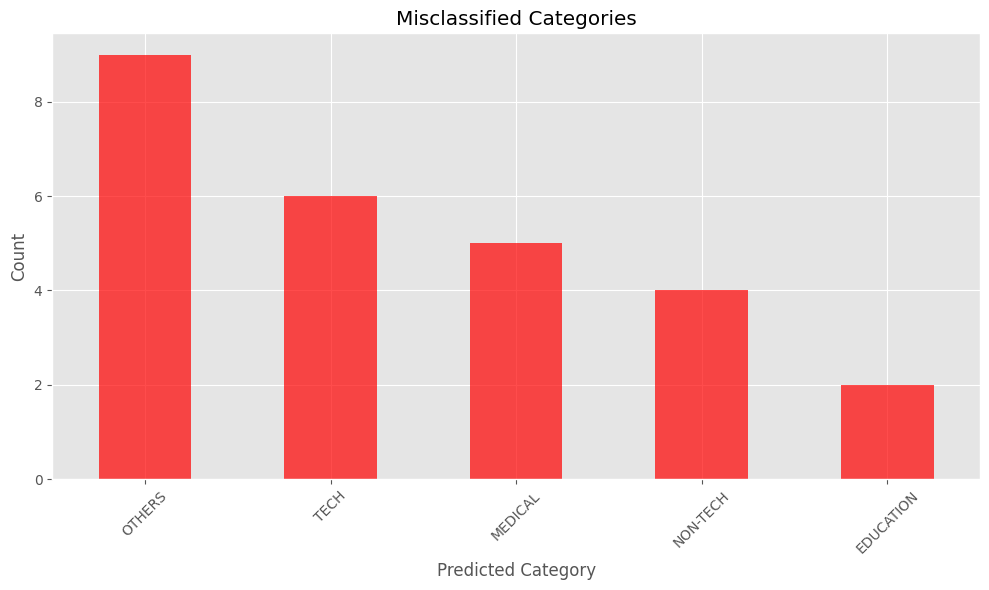

In [40]:
# Filter misclassified examples
misclassified = test_df_with_predictions[test_df_with_predictions['Predicted_Label'] != test_df_with_predictions['Actual_Label']]

# Display some of the misclassified examples
print(misclassified[['Actual_Category', 'Predicted_Category']].head(10))

# You can also visualize the misclassified examples in a bar plot
misclassified_counts = misclassified['Predicted_Category'].value_counts()

# Bar plot of misclassified predictions
plt.figure(figsize=(10, 6))
misclassified_counts.plot(kind='bar', color='red', alpha=0.7)
plt.title('Misclassified Categories')
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [41]:
model = BertForSequenceClassification.from_pretrained("./combined_category_model")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [42]:
def predict_resume_category(resume_text):
    inputs = tokenizer(resume_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return label_mapping[predicted_class_id]


In [43]:
def extract_text_from_pdf(pdf_path):
    from PyPDF2 import PdfReader
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# Example usage
uploaded_resume = "/kaggle/input/resume-dataset/data/data/ADVOCATE/10186968.pdf"  # Replace with user-uploaded file path
resume_text = extract_text_from_pdf(uploaded_resume)
predicted_category = predict_resume_category(resume_text)
print("Predicted Category:", predicted_category)


Predicted Category: LEGAL


In [44]:
import pandas as pd

# Assuming the test_df_with_predictions DataFrame contains all columns and predictions
# Add the actual labels and predicted labels into the DataFrame
test_df_with_predictions['Predicted_Label'] = preds
test_df_with_predictions['Actual_Label'] = labels

# Map the label indices to their respective category names (if needed)
test_df_with_predictions['Predicted_Category'] = test_df_with_predictions['Predicted_Label'].map(lambda x: label_mapping[x])
test_df_with_predictions['Actual_Category'] = test_df_with_predictions['Actual_Label'].map(lambda x: label_mapping[x])

# Save the entire DataFrame with predictions to the 'output' directory
test_df_with_predictions.to_csv('/kaggle/working/test_predictions.csv', index=False)

# Print the first few rows to check
print(test_df_with_predictions.head())


            ID                                             Resume  \
975   23933031           SR. WORKFORCE MANAGER       Summary  ...   
602   39237915           BUSINESS DEVELOPMENT MANAGER       Pr...   
1708  38535335           ENGINEERING COORDINATOR       Summary...   
1593  24533931           APPAREL ASSOCIATE       Summary    An...   
1360  19007667           CHEF       Summary     Experienced ca...   

     Combined_Category  label  Predicted_Label  Actual_Label  \
975             OTHERS      4                4             4   
602             OTHERS      4                4             4   
1708              TECH      5                5             5   
1593            OTHERS      4                4             4   
1360            OTHERS      4                4             4   

     Predicted_Category Actual_Category  
975              OTHERS          OTHERS  
602              OTHERS          OTHERS  
1708               TECH            TECH  
1593             OTHERS         

# PART 2 Starts

In [ ]:
# Cell 1: Import Required Libraries
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer
from datasets import Dataset
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore", message="A parameter name that contains beta will be renamed internally to bias")

In [45]:
# Cell 2: Load and Prepare Dataset
# Load the dataset
data = pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")

# Intelligent Category Grouping
category_groups = {
    'TECH': ['INFORMATION-TECHNOLOGY', 'ENGINEERING', 'AUTOMOBILE'],
    'BUSINESS': ['BUSINESS-DEVELOPMENT', 'ACCOUNTANT', 'FINANCE', 'SALES', 'BANKING', 'CONSULTANT'],
    'LEGAL': ['ADVOCATE'],
    'CREATIVE': ['CHEF'],
    'HEALTHCARE': ['FITNESS', 'HEALTHCARE'],
    'TRANSPORTATION': ['AVIATION'],
    'MARKETING': ['PUBLIC-RELATIONS', 'DIGITAL-MEDIA'],
    'EDUCATION': ['HR', 'TEACHER'],
    'DESIGN': ['DESIGNER'],
    'CONSTRUCTION': ['CONSTRUCTION'],
    'APPAREL': ['APPAREL'],
    'AGRICULTURE': ['AGRICULTURE'],
    'OTHERS': ['BPO']
}
# Function to map categories
def map_to_group_category(category):
    for group, categories in category_groups.items():
        if category in categories:
            return group
    return 'OTHERS'

# Apply category mapping
data['Grouped_Category'] = data['Category'].apply(map_to_group_category)

# Create label encoding
data['label'] = data['Grouped_Category'].astype('category').cat.codes
label_mapping = dict(enumerate(data['Grouped_Category'].astype('category').cat.categories))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'AGRICULTURE', 1: 'APPAREL', 2: 'BUSINESS', 3: 'CONSTRUCTION', 4: 'CREATIVE', 5: 'DESIGN', 6: 'EDUCATION', 7: 'HEALTHCARE', 8: 'LEGAL', 9: 'MARKETING', 10: 'OTHERS', 11: 'TECH', 12: 'TRANSPORTATION'}


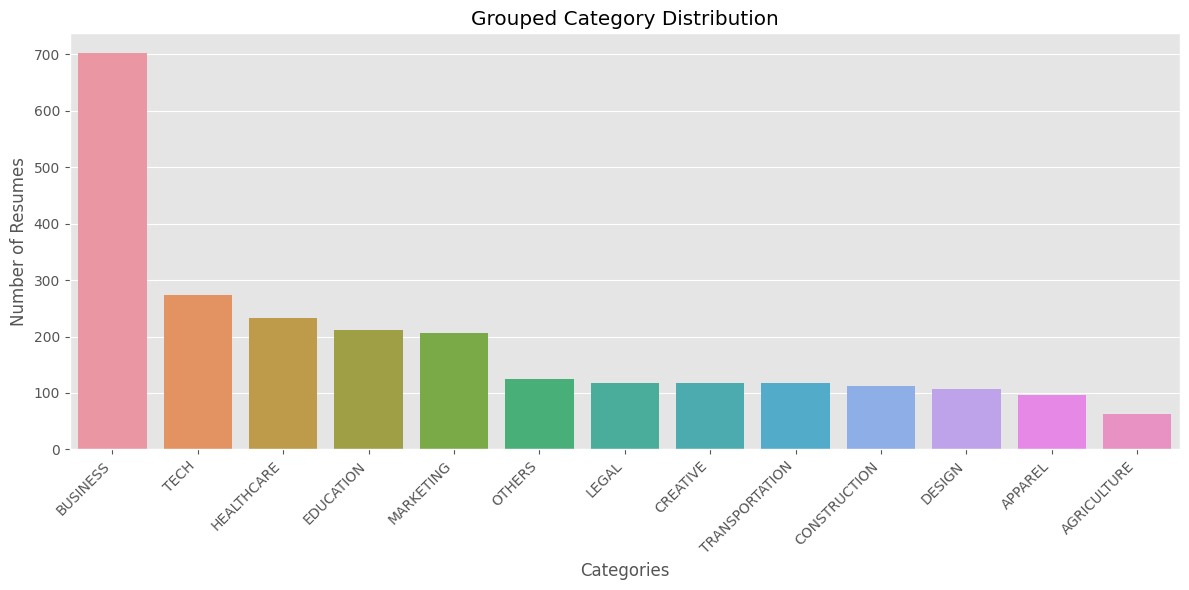

In [46]:
# Cell 3: Visualization of Category Distribution
plt.figure(figsize=(12, 6))
category_counts = data['Grouped_Category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Grouped Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
# Cell 4: Prepare Dataset
# Prepare the dataframe
df = data.drop(columns=["Resume_html", "Category"]).rename(columns={"Resume_str": "Resume"})

# Train-Test-Validation Split
train, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val, test = train_test_split(temp, test_size=0.3, stratify=temp['label'], random_state=42)
print("Train shape:", train.shape, "Validation shape:", val.shape, "Test shape:", test.shape)

Train shape: (1738, 4) Validation shape: (522, 4) Test shape: (224, 4)


In [ ]:
# Cell 4: Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Resume"], padding="max_length", truncation=True, max_length=512)

# Convert dataframes to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set dataset format
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [49]:
model = BertForSequenceClassification.from_pretrained("./combined_category_model")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [50]:
print("Number of labels in previous model:", model.config.num_labels)
print("Number of labels in new model:", len(label_mapping))

Number of labels in previous model: 6
Number of labels in new model: 13


In [51]:
# Load the base BERT model with the correct number of labels
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=len(label_mapping)
)

# Load the previous model to extract its state dictionary
previous_model = BertForSequenceClassification.from_pretrained("./combined_category_model")

# Get the state dictionary of the previous model
state_dict = previous_model.state_dict()

# Remove classifier layers from the state dict
# This filters out the classification layer weights that don't match
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}

# Load the filtered state dict
# strict=False allows loading partial state dict
model.load_state_dict(state_dict, strict=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=[])

In [52]:
# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [53]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./original_category_model_from_combined",
    evaluation_strategy="epoch",
    learning_rate=1e-5,  # Lower learning rate for fine-tuning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Potentially fewer epochs as we're fine-tuning
    weight_decay=0.01,
    logging_dir="./logs_original_from_combined",
    logging_steps=10,
    save_total_limit=2,
    save_strategy="epoch",
)


In [54]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [55]:
# Train the model (fine-tuning)
trainer.train()

# Save the fine-tuned model
trainer.save_model("./original_category_model_from_combined")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.269400,1.171788,0.777778,0.790085,0.777778,0.743826
2,1.007600,0.828378,0.835249,0.826717,0.835249,0.816640
3,0.619000,0.698772,0.850575,0.838322,0.850575,0.836103
4,0.585200,0.640893,0.856322,0.866917,0.856322,0.847408
5,0.527700,0.627530,0.858238,0.862990,0.858238,0.851875


Evaluation Metrics: {'eval_loss': 0.669270396232605, 'eval_accuracy': 0.8526785714285714, 'eval_precision': 0.8478973118514486, 'eval_recall': 0.8526785714285714, 'eval_f1': 0.8438680702467468, 'eval_runtime': 3.4944, 'eval_samples_per_second': 64.103, 'eval_steps_per_second': 4.006, 'epoch': 5.0}


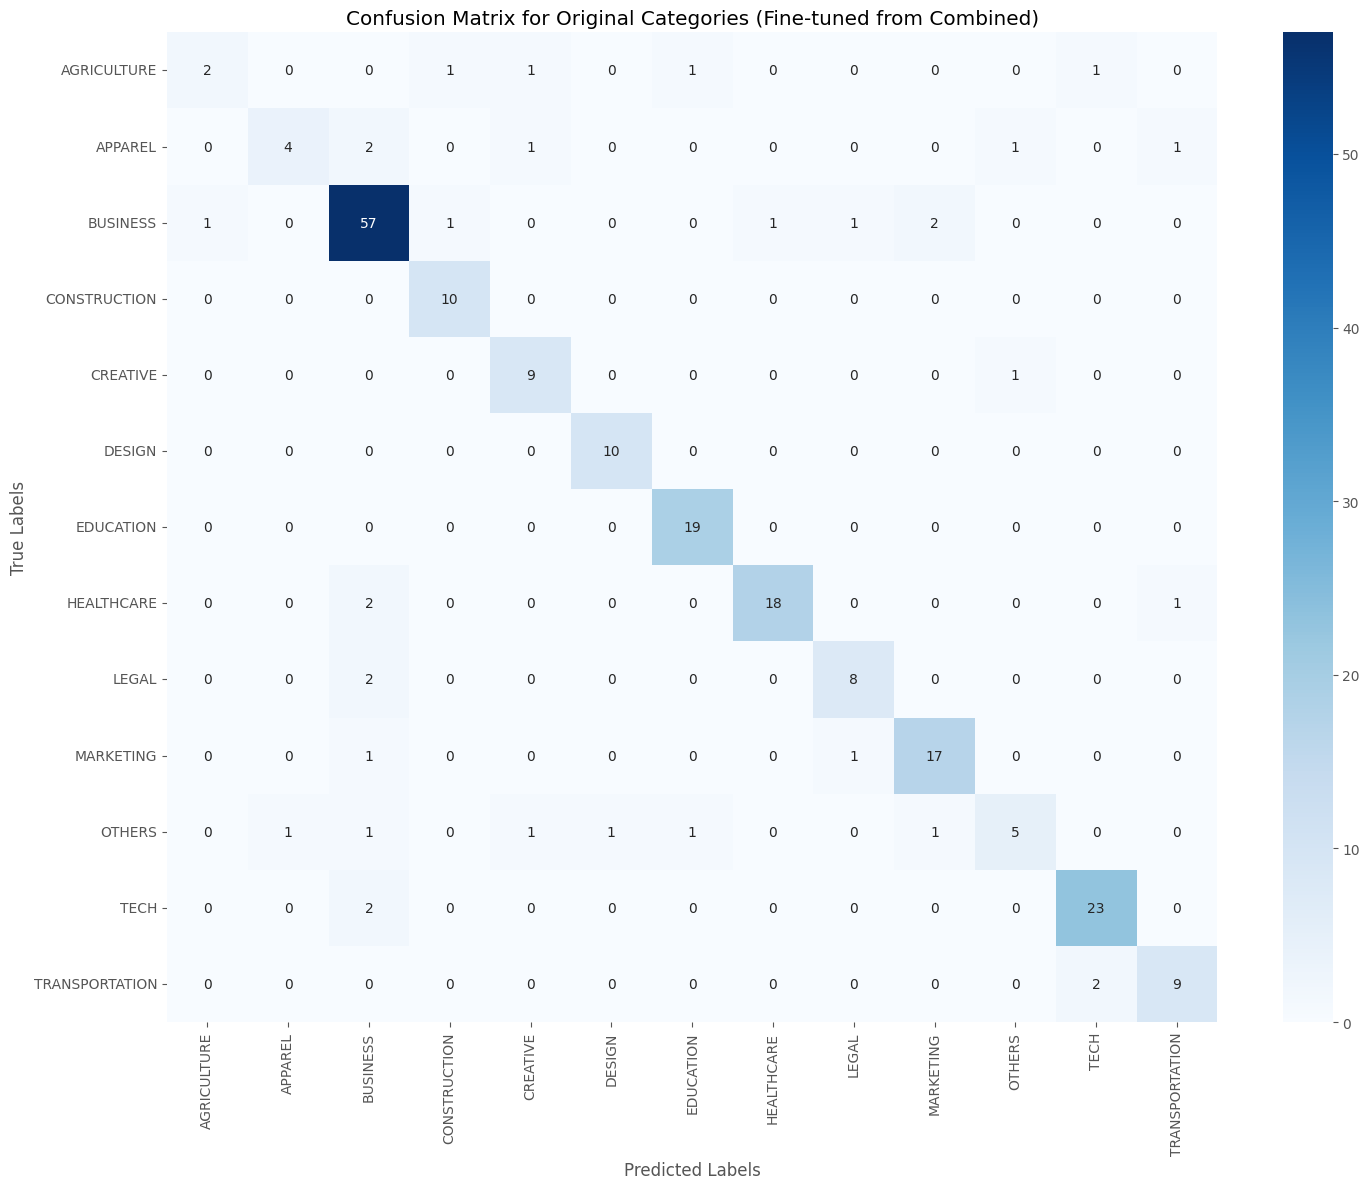

In [56]:
# Cell 6: Evaluation and Visualization
# Evaluate on test set
metrics = trainer.evaluate(test_dataset)
print("Evaluation Metrics:", metrics)

# Predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Confusion Matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_mapping.values(), 
            yticklabels=label_mapping.values())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Original Categories (Fine-tuned from Combined)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [57]:
# Cell 7: Prepare Results DataFrame
test_df_with_predictions = test.copy()
test_df_with_predictions['Predicted_Label'] = preds
test_df_with_predictions['Actual_Label'] = labels

# Map label indices to their corresponding category names
test_df_with_predictions['Predicted_Category'] = test_df_with_predictions['Predicted_Label'].map(lambda x: label_mapping.get(x))
test_df_with_predictions['Actual_Category'] = test_df_with_predictions['Actual_Label'].map(lambda x: label_mapping.get(x))

# Save the entire DataFrame with predictions
test_df_with_predictions.to_csv('/kaggle/working/original_categories_from_combined_test_predictions.csv', index=False)

# Display comparison of actual vs predicted
print(test_df_with_predictions[['Actual_Category', 'Predicted_Category']])

# Classification Report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=label_mapping.values()))

     Actual_Category Predicted_Category
1709            TECH               TECH
1768            TECH               TECH
2044       MARKETING          MARKETING
2014    CONSTRUCTION       CONSTRUCTION
169           DESIGN             DESIGN
...              ...                ...
2472  TRANSPORTATION     TRANSPORTATION
1497        BUSINESS           BUSINESS
2015    CONSTRUCTION       CONSTRUCTION
419        EDUCATION          EDUCATION
2089       MARKETING          MARKETING

[224 rows x 2 columns]

Classification Report:
                precision    recall  f1-score   support

   AGRICULTURE       0.67      0.33      0.44         6
       APPAREL       0.80      0.44      0.57         9
      BUSINESS       0.85      0.90      0.88        63
  CONSTRUCTION       0.83      1.00      0.91        10
      CREATIVE       0.75      0.90      0.82        10
        DESIGN       0.91      1.00      0.95        10
     EDUCATION       0.90      1.00      0.95        19
    HEALTHCARE       0.

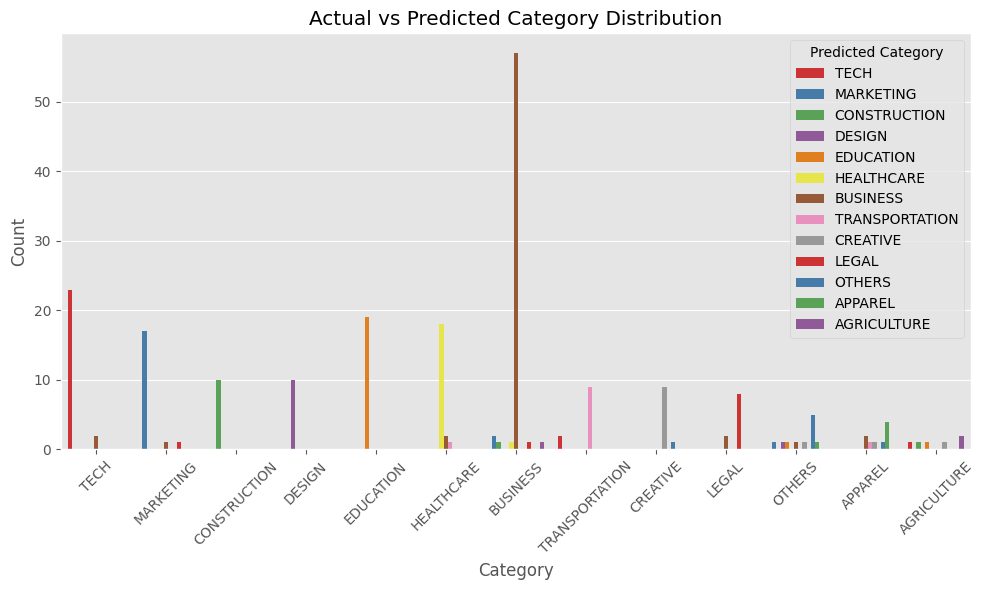

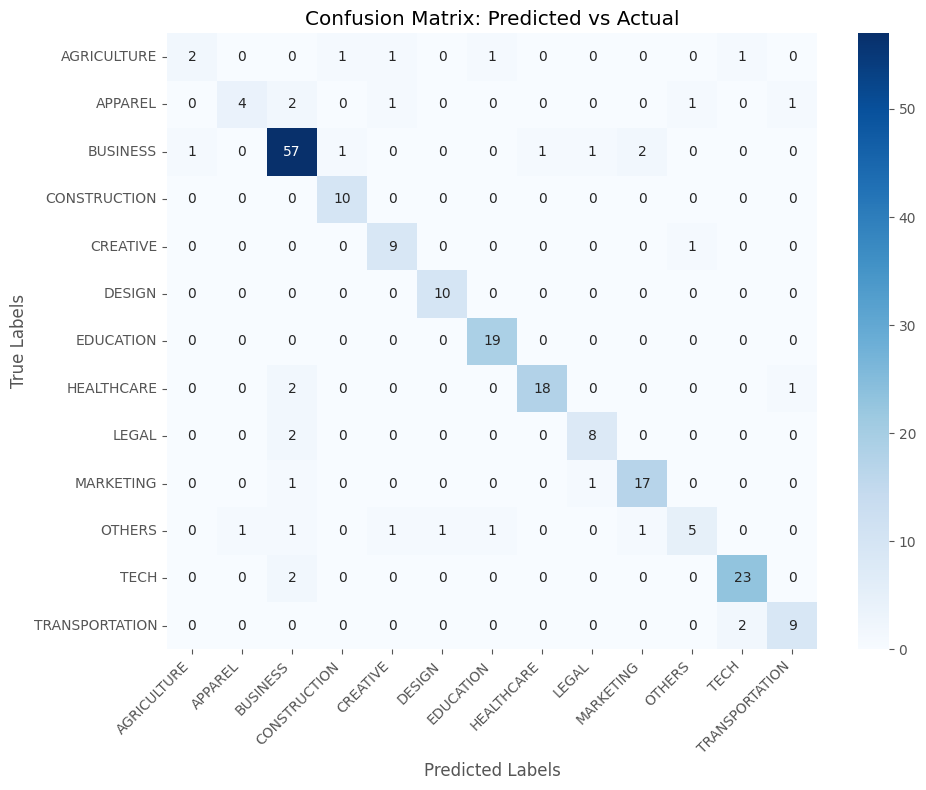


Classification Report:

                precision    recall  f1-score   support

   AGRICULTURE       0.67      0.33      0.44         6
       APPAREL       0.80      0.44      0.57         9
      BUSINESS       0.85      0.90      0.88        63
  CONSTRUCTION       0.83      1.00      0.91        10
      CREATIVE       0.75      0.90      0.82        10
        DESIGN       0.91      1.00      0.95        10
     EDUCATION       0.90      1.00      0.95        19
    HEALTHCARE       0.95      0.86      0.90        21
         LEGAL       0.80      0.80      0.80        10
     MARKETING       0.85      0.89      0.87        19
        OTHERS       0.71      0.45      0.56        11
          TECH       0.88      0.92      0.90        25
TRANSPORTATION       0.82      0.82      0.82        11

      accuracy                           0.85       224
     macro avg       0.83      0.79      0.80       224
  weighted avg       0.85      0.85      0.84       224



In [58]:
plt.figure(figsize=(10, 6))
sns.countplot(data=test_df_with_predictions, x='Actual_Category', hue='Predicted_Category', palette='Set1')
plt.title("Actual vs Predicted Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Predicted Category")
plt.tight_layout()
plt.show()

# 2. Confusion Matrix Visualization
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Predicted vs Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Classification Report (optional, as text)
print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=label_mapping.values()))

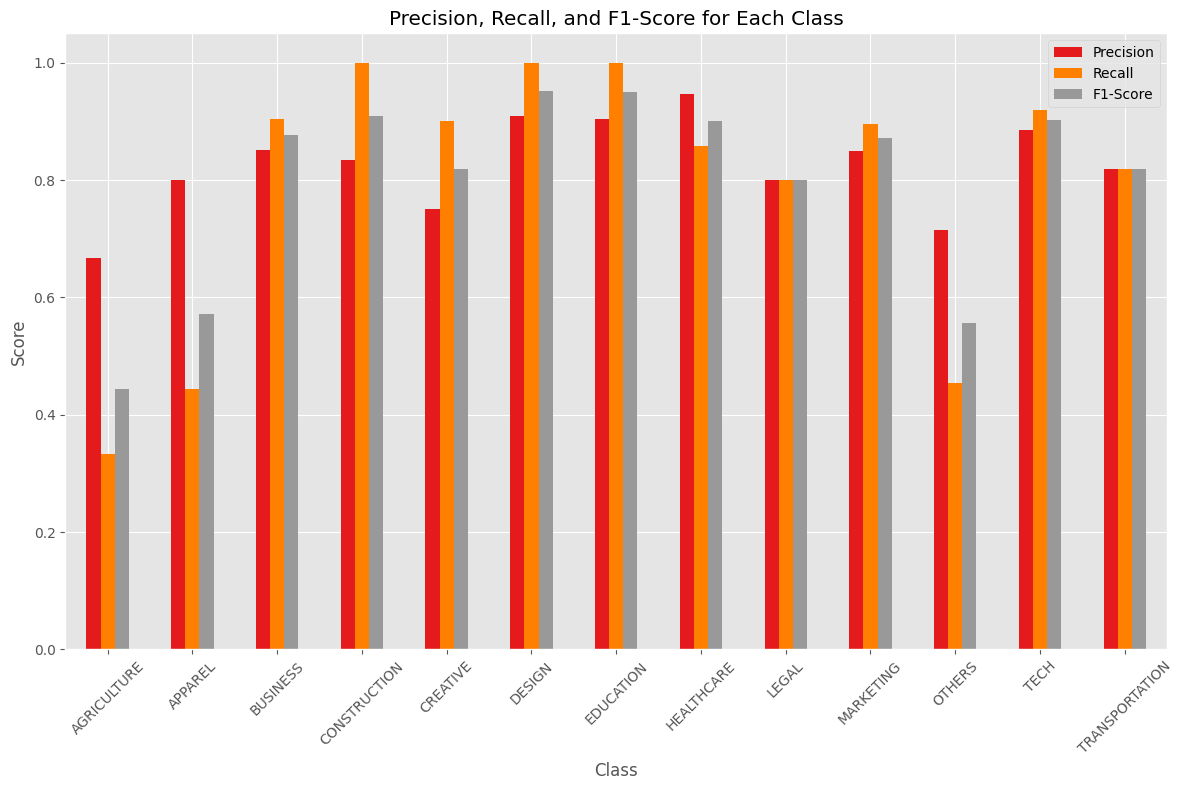

In [59]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, and f1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)

# Create a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Class': label_mapping.values(),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Plot Precision, Recall, and F1-Score for each class
metrics_df.set_index('Class').plot(kind='bar', figsize=(12, 8), colormap='Set1')
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


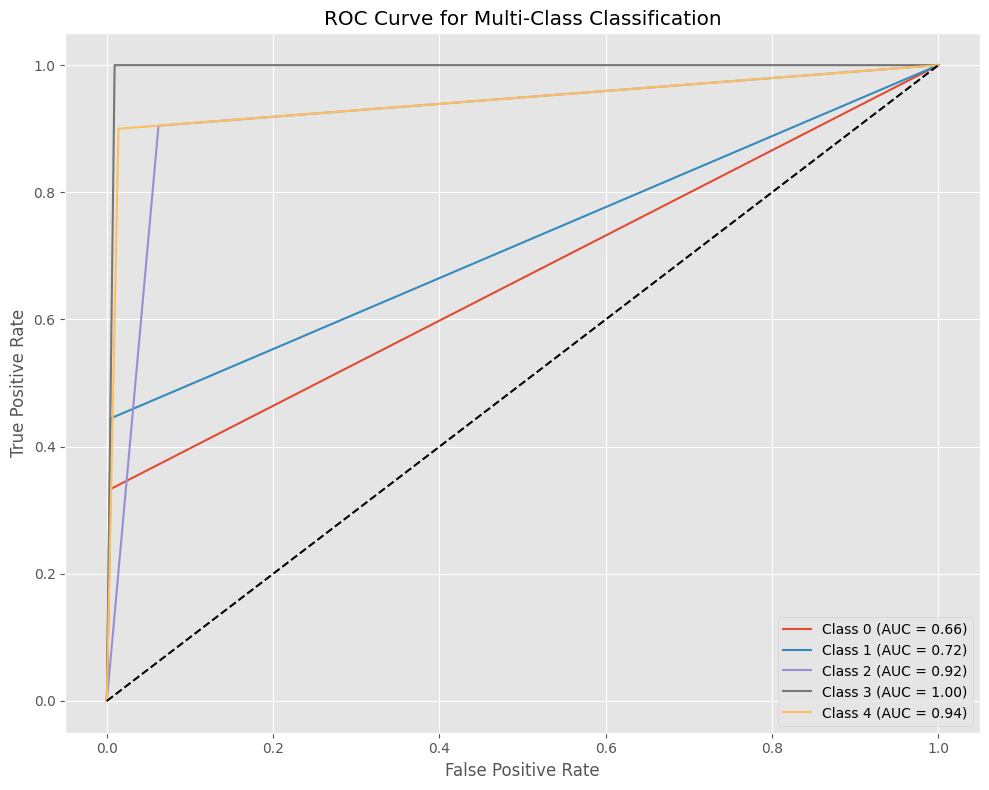

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC curve (if needed)
labels_bin = label_binarize(labels, classes=[0, 1, 2, 3, 4])  # Adjust based on your number of classes
preds_bin = label_binarize(preds, classes=[0, 1, 2, 3, 4])  # Adjust based on your number of classes

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(labels_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(labels_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve for Multi-Class Classification")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


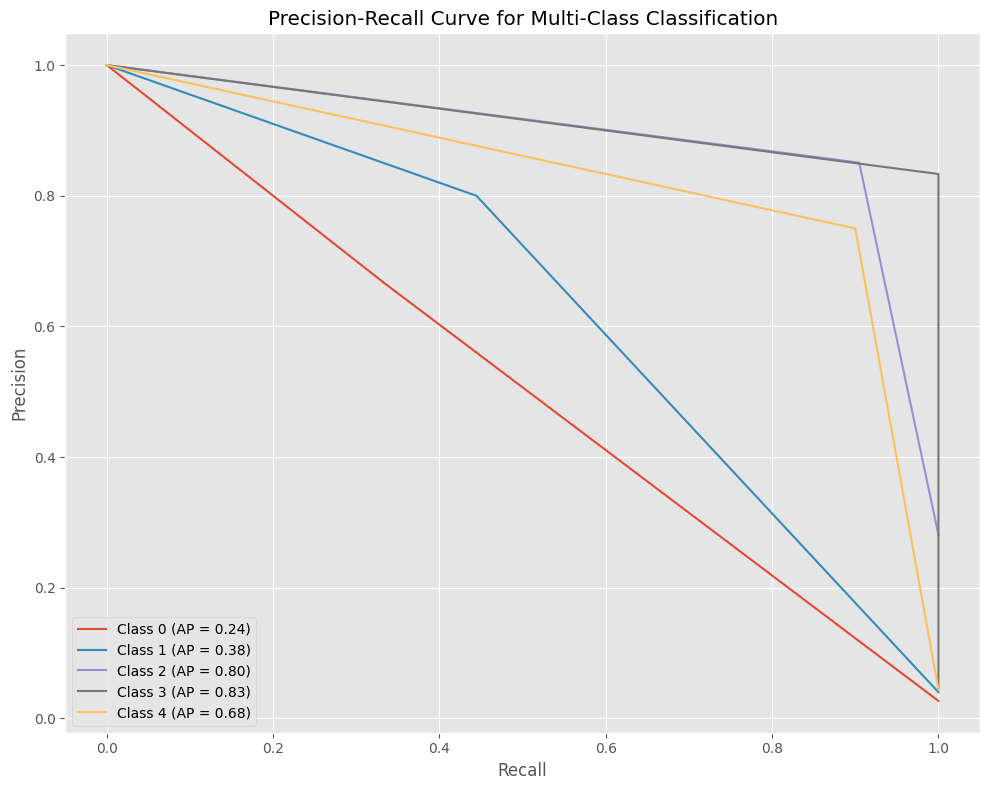

In [61]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Calculate Precision-Recall curve for each class
precisions, recalls, _ = {}, {}, {}
average_precisions = {}

for i in range(labels_bin.shape[1]):
    precisions[i], recalls[i], _ = precision_recall_curve(labels_bin[:, i], preds_bin[:, i])
    average_precisions[i] = average_precision_score(labels_bin[:, i], preds_bin[:, i])

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
for i in range(labels_bin.shape[1]):
    plt.plot(recalls[i], precisions[i], label=f'Class {i} (AP = {average_precisions[i]:.2f})')

plt.title("Precision-Recall Curve for Multi-Class Classification")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


     Actual_Category Predicted_Category
2120       MARKETING           BUSINESS
1646         APPAREL           CREATIVE
2359          OTHERS          MARKETING
2252        BUSINESS          MARKETING
2095       MARKETING              LEGAL
853       HEALTHCARE           BUSINESS
2245        BUSINESS        AGRICULTURE
542            LEGAL           BUSINESS
931      AGRICULTURE               TECH
549            LEGAL           BUSINESS


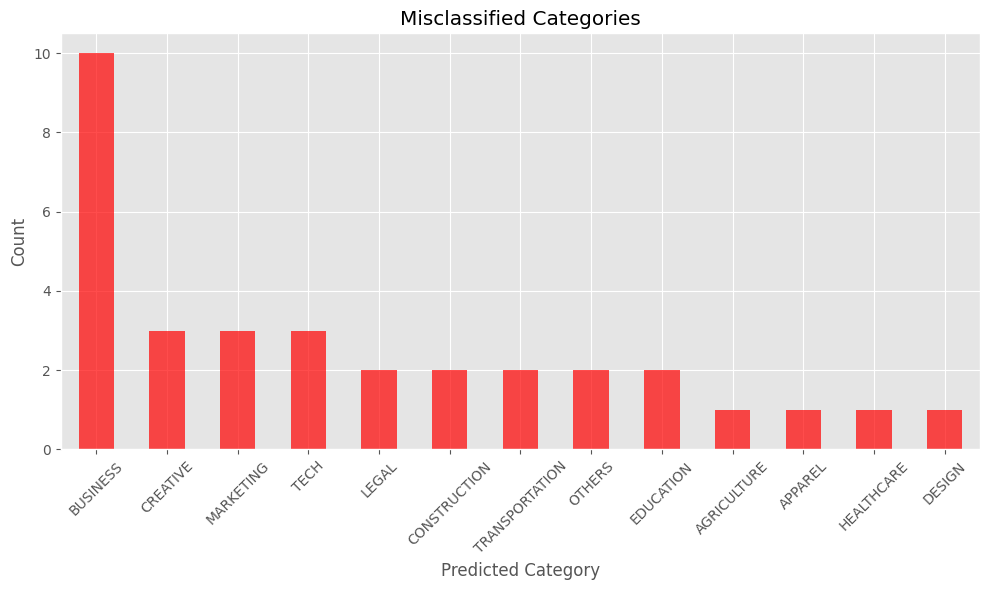

In [62]:
# Filter misclassified examples
misclassified = test_df_with_predictions[test_df_with_predictions['Predicted_Label'] != test_df_with_predictions['Actual_Label']]

# Display some of the misclassified examples
print(misclassified[['Actual_Category', 'Predicted_Category']].head(10))

# You can also visualize the misclassified examples in a bar plot
misclassified_counts = misclassified['Predicted_Category'].value_counts()

# Bar plot of misclassified predictions
plt.figure(figsize=(10, 6))
misclassified_counts.plot(kind='bar', color='red', alpha=0.7)
plt.title('Misclassified Categories')
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [63]:
model = BertForSequenceClassification.from_pretrained("./original_category_model_from_combined")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [64]:
def predict_resume_category(resume_text):
    inputs = tokenizer(resume_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return label_mapping[predicted_class_id]


In [65]:
def extract_text_from_pdf(pdf_path):
    from PyPDF2 import PdfReader
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# Example usage
uploaded_resume = "/kaggle/input/resume-dataset/data/data/PUBLIC-RELATIONS/10554045.pdf"  # Replace with user-uploaded file path
resume_text = extract_text_from_pdf(uploaded_resume)
predicted_category = predict_resume_category(resume_text)
print("Predicted Category:", predicted_category)


Predicted Category: MARKETING


# PART 3 Starts

In [ ]:
# Cell 1: Import Required Libraries
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer
from datasets import Dataset
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore", message="A parameter name that contains beta will be renamed internally to bias")

In [66]:
# Cell 2: Load and Prepare Dataset
# Load the dataset
data = pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")

# Intelligent Category Grouping
category_groups ={
    'INFORMATION_TECHNOLOGY': ['INFORMATION-TECHNOLOGY'],
    'ENGINEERING': ['ENGINEERING'],
    'AUTOMOBILE': ['AUTOMOBILE'],
    'BUSINESS_DEVELOPMENT': ['BUSINESS-DEVELOPMENT'],
    'ACCOUNTING': ['ACCOUNTANT'],
    'FINANCE': ['FINANCE'],
    'SALES': ['SALES'],
    'BANKING': ['BANKING'],
    'CONSULTING': ['CONSULTANT'],
    'LEGAL': ['ADVOCATE'],
    'CREATIVE': ['CHEF'],
    'ARTS': ['ARTS', 'DESIGNER'],  # Added a separate category for arts
    'HEALTHCARE': ['FITNESS', 'HEALTHCARE'],
    'AVIATION': ['AVIATION'],
    'MARKETING': ['PUBLIC-RELATIONS', 'DIGITAL-MEDIA'],
    'EDUCATION': ['HR', 'TEACHER'],
    'CONSTRUCTION': ['CONSTRUCTION'],
    'OTHERS': ['BPO', 'APPAREL', 'AGRICULTURE']
}


# Function to map categories
def map_to_group_category(category):
    for group, categories in category_groups.items():
        if category in categories:
            return group
    return 'OTHERS'

# Apply category mapping
data['Grouped_Category'] = data['Category'].apply(map_to_group_category)

# Create label encoding
data['label'] = data['Grouped_Category'].astype('category').cat.codes
label_mapping = dict(enumerate(data['Grouped_Category'].astype('category').cat.categories))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'ACCOUNTING', 1: 'ARTS', 2: 'AUTOMOBILE', 3: 'AVIATION', 4: 'BANKING', 5: 'BUSINESS_DEVELOPMENT', 6: 'CONSTRUCTION', 7: 'CONSULTING', 8: 'CREATIVE', 9: 'EDUCATION', 10: 'ENGINEERING', 11: 'FINANCE', 12: 'HEALTHCARE', 13: 'INFORMATION_TECHNOLOGY', 14: 'LEGAL', 15: 'MARKETING', 16: 'OTHERS', 17: 'SALES'}


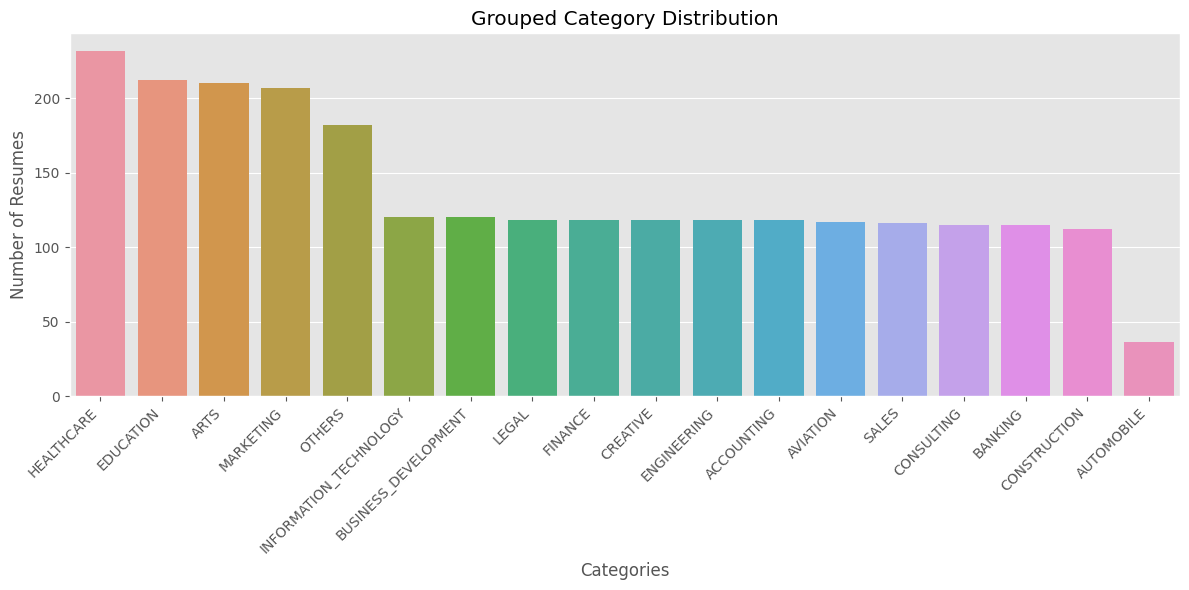

In [67]:
# Cell 3: Visualization of Category Distribution
plt.figure(figsize=(12, 6))
category_counts = data['Grouped_Category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Grouped Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [68]:
# Cell 4: Prepare Dataset
# Prepare the dataframe
df = data.drop(columns=["Resume_html", "Category"]).rename(columns={"Resume_str": "Resume"})

# Train-Test-Validation Split
train, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val, test = train_test_split(temp, test_size=0.3, stratify=temp['label'], random_state=42)
print("Train shape:", train.shape, "Validation shape:", val.shape, "Test shape:", test.shape)

Train shape: (1738, 4) Validation shape: (522, 4) Test shape: (224, 4)


In [ ]:
# Cell 4: Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Resume"], padding="max_length", truncation=True, max_length=512)

# Convert dataframes to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set dataset format
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [70]:
model = BertForSequenceClassification.from_pretrained("./original_category_model_from_combined")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [71]:
print("Number of labels in previous model:", model.config.num_labels)
print("Number of labels in new model:", len(label_mapping))

Number of labels in previous model: 13
Number of labels in new model: 18


In [72]:
# Load the base BERT model with the correct number of labels
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=len(label_mapping)
)

# Load the previous model to extract its state dictionary
previous_model = BertForSequenceClassification.from_pretrained("./original_category_model_from_combined")

# Get the state dictionary of the previous model
state_dict = previous_model.state_dict()

# Remove classifier layers from the state dict
# This filters out the classification layer weights that don't match
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}

# Load the filtered state dict
# strict=False allows loading partial state dict
model.load_state_dict(state_dict, strict=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=[])

In [73]:
# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [74]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./Soriginal_category_model_from_combinedsss",
    evaluation_strategy="epoch",
    learning_rate=1e-5,  # Lower learning rate for fine-tuning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Potentially fewer epochs as we're fine-tuning
    weight_decay=0.01,
    logging_dir="./logs_original_from_combined",
    logging_steps=10,
    save_total_limit=2,
    save_strategy="epoch",
)


In [75]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [76]:
# Train the model (fine-tuning)
trainer.train()

# Save the fine-tuned model
trainer.save_model("./Soriginal_category_model_from_combined18sss")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.501300,1.229346,0.812261,0.818892,0.812261,0.793728
2,0.862200,0.848116,0.856322,0.848778,0.856322,0.841452
3,0.641300,0.704176,0.863985,0.851926,0.863985,0.853529
4,0.687600,0.637897,0.867816,0.860489,0.867816,0.860901
5,0.552100,0.617384,0.869732,0.863880,0.869732,0.864185


Evaluation Metrics: {'eval_loss': 0.5532336831092834, 'eval_accuracy': 0.8883928571428571, 'eval_precision': 0.879087430426716, 'eval_recall': 0.8883928571428571, 'eval_f1': 0.8812009205582448, 'eval_runtime': 3.4954, 'eval_samples_per_second': 64.083, 'eval_steps_per_second': 4.005, 'epoch': 5.0}


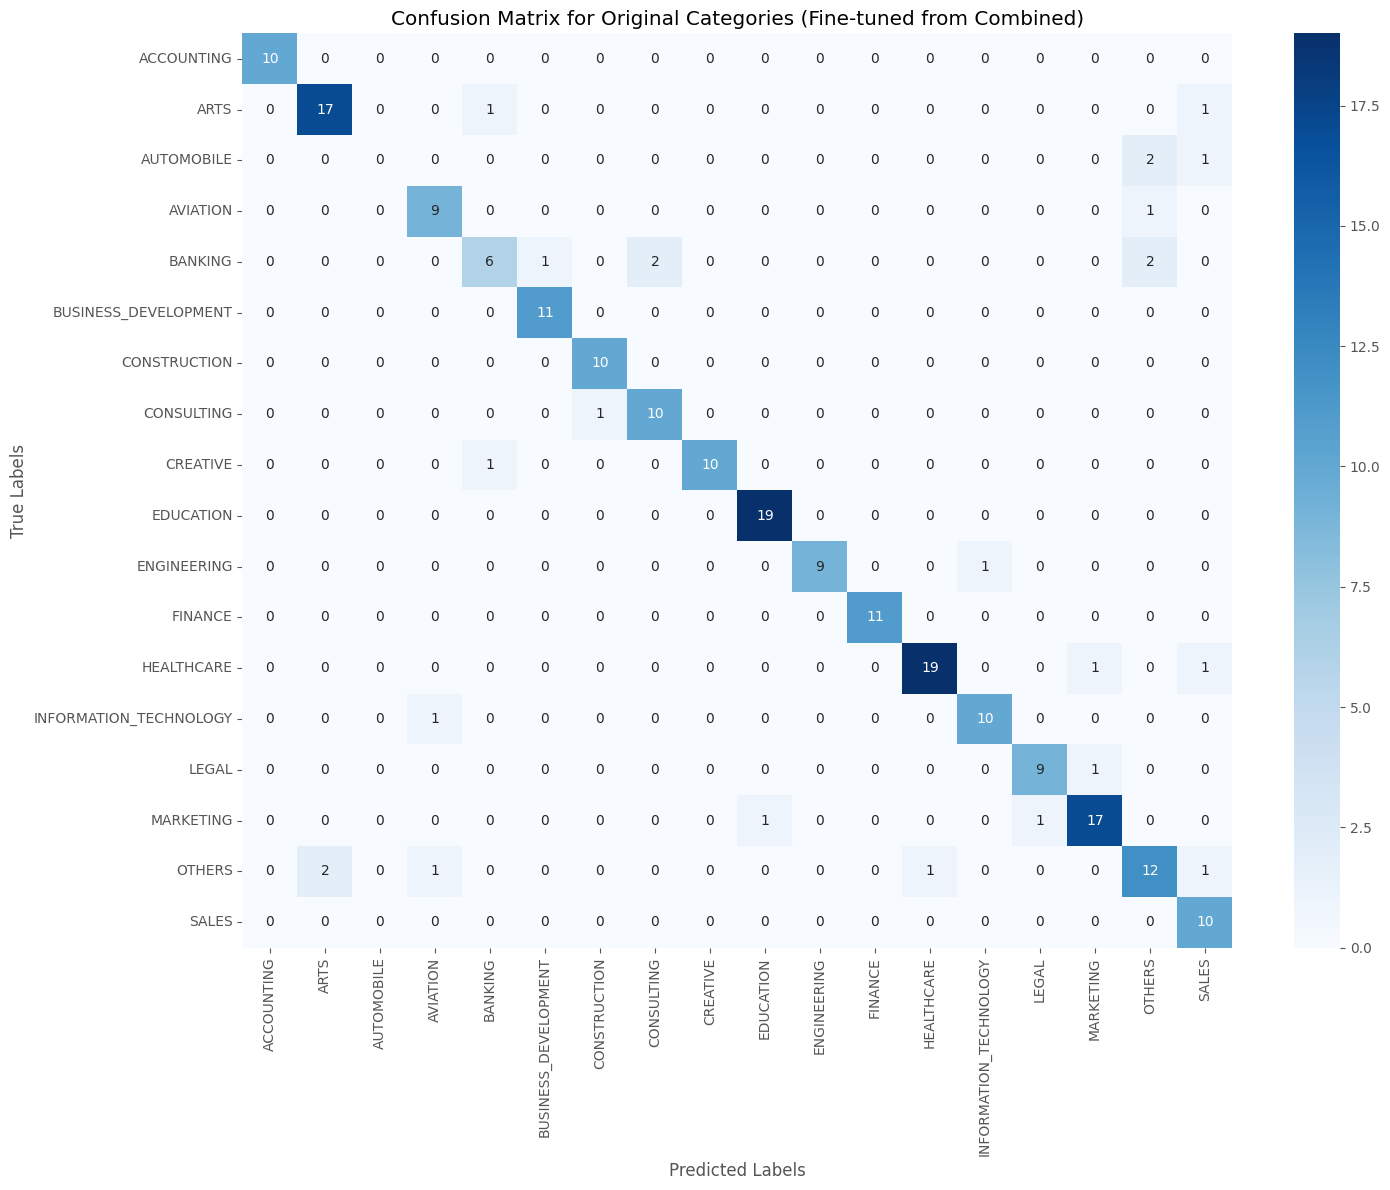

In [77]:
# Cell 6: Evaluation and Visualization
# Evaluate on test set
metrics = trainer.evaluate(test_dataset)
print("Evaluation Metrics:", metrics)

# Predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Confusion Matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_mapping.values(), 
            yticklabels=label_mapping.values())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Original Categories (Fine-tuned from Combined)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [78]:
# Cell 7: Prepare Results DataFrame
test_df_with_predictions = test.copy()
test_df_with_predictions['Predicted_Label'] = preds
test_df_with_predictions['Actual_Label'] = labels

# Map label indices to their corresponding category names
test_df_with_predictions['Predicted_Category'] = test_df_with_predictions['Predicted_Label'].map(lambda x: label_mapping.get(x))
test_df_with_predictions['Actual_Category'] = test_df_with_predictions['Actual_Label'].map(lambda x: label_mapping.get(x))

# Save the entire DataFrame with predictions
test_df_with_predictions.to_csv('/kaggle/working/original_categories_from_combined_test_predictions18.csv', index=False)

# Display comparison of actual vs predicted
print(test_df_with_predictions[['Actual_Category', 'Predicted_Category']])

# Classification Report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=label_mapping.values()))

             Actual_Category      Predicted_Category
982                   OTHERS                AVIATION
943                   OTHERS              HEALTHCARE
325   INFORMATION_TECHNOLOGY  INFORMATION_TECHNOLOGY
1186              CONSULTING              CONSULTING
426                EDUCATION               EDUCATION
...                      ...                     ...
1099                   SALES                   SALES
570     BUSINESS_DEVELOPMENT    BUSINESS_DEVELOPMENT
1389                CREATIVE                CREATIVE
1746             ENGINEERING             ENGINEERING
249   INFORMATION_TECHNOLOGY  INFORMATION_TECHNOLOGY

[224 rows x 2 columns]

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTING       1.00      1.00      1.00        10
                  ARTS       0.89      0.89      0.89        19
            AUTOMOBILE       0.00      0.00      0.00         3
              AVIATION       0.82      0.90      0.86      

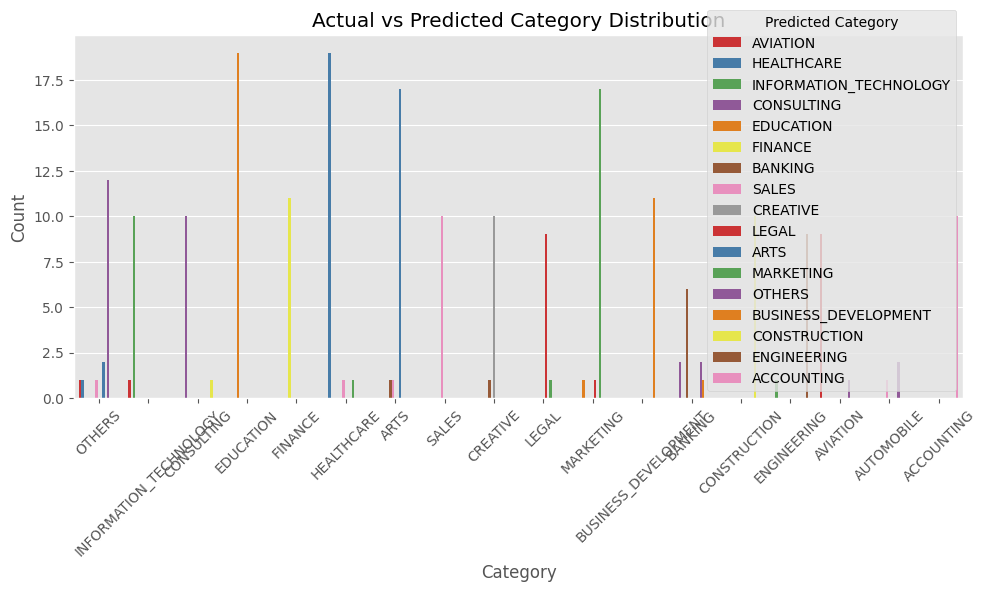

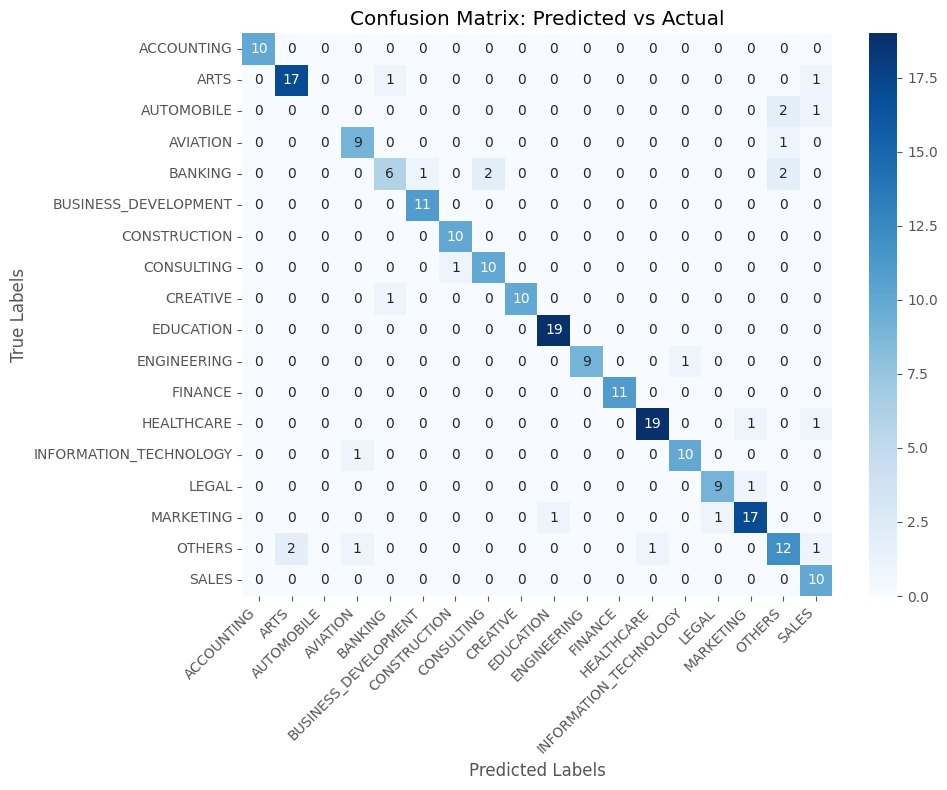


Classification Report:

                        precision    recall  f1-score   support

            ACCOUNTING       1.00      1.00      1.00        10
                  ARTS       0.89      0.89      0.89        19
            AUTOMOBILE       0.00      0.00      0.00         3
              AVIATION       0.82      0.90      0.86        10
               BANKING       0.75      0.55      0.63        11
  BUSINESS_DEVELOPMENT       0.92      1.00      0.96        11
          CONSTRUCTION       0.91      1.00      0.95        10
            CONSULTING       0.83      0.91      0.87        11
              CREATIVE       1.00      0.91      0.95        11
             EDUCATION       0.95      1.00      0.97        19
           ENGINEERING       1.00      0.90      0.95        10
               FINANCE       1.00      1.00      1.00        11
            HEALTHCARE       0.95      0.90      0.93        21
INFORMATION_TECHNOLOGY       0.91      0.91      0.91        11
              

In [79]:
plt.figure(figsize=(10, 6))
sns.countplot(data=test_df_with_predictions, x='Actual_Category', hue='Predicted_Category', palette='Set1')
plt.title("Actual vs Predicted Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Predicted Category")
plt.tight_layout()
plt.show()

# 2. Confusion Matrix Visualization
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Predicted vs Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Classification Report (optional, as text)
print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=label_mapping.values()))

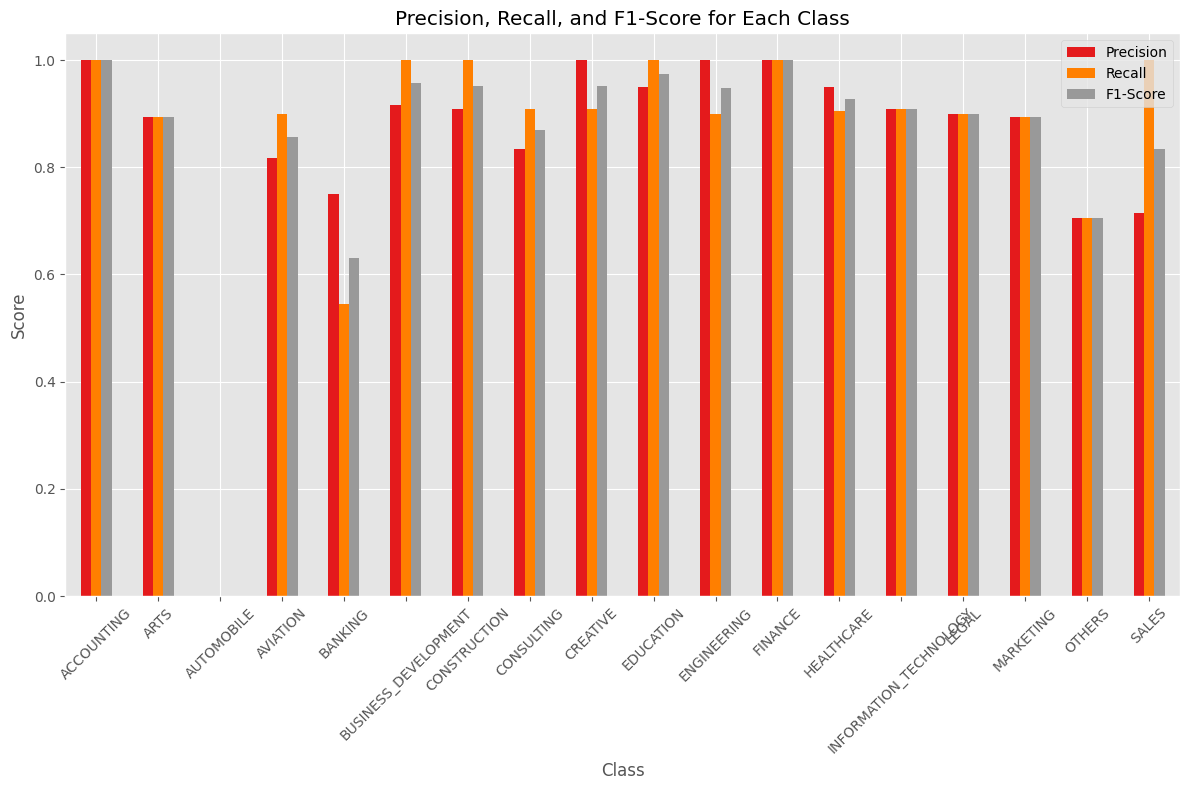

In [80]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, and f1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)

# Create a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Class': label_mapping.values(),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Plot Precision, Recall, and F1-Score for each class
metrics_df.set_index('Class').plot(kind='bar', figsize=(12, 8), colormap='Set1')
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


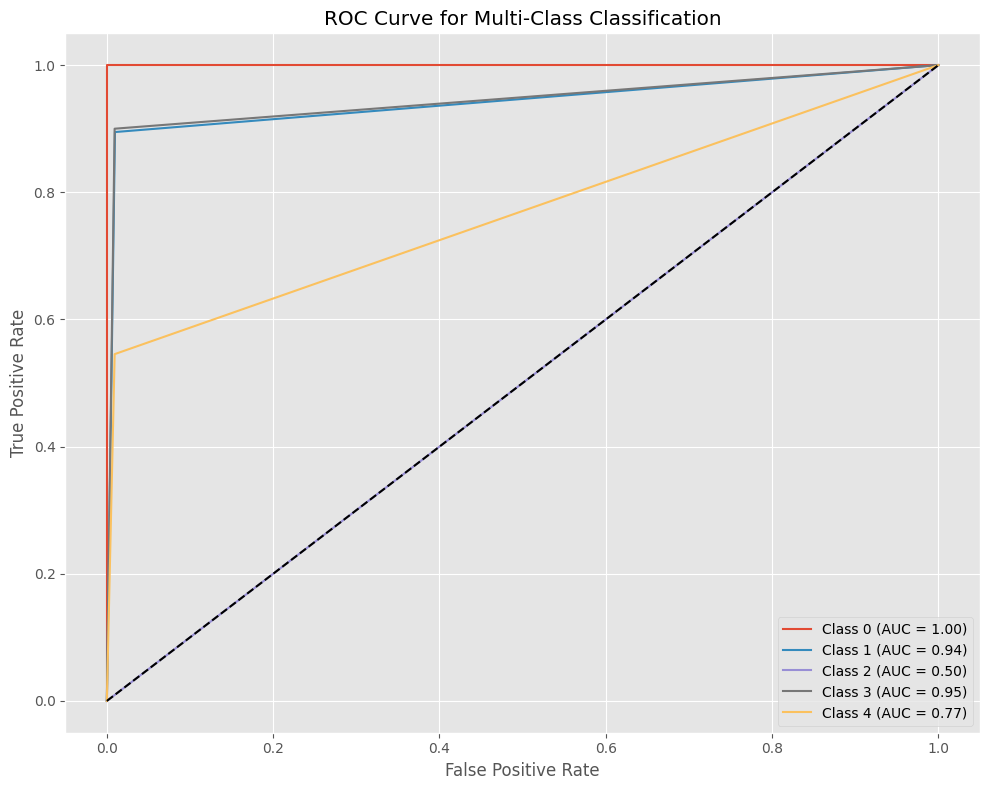

In [81]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC curve (if needed)
labels_bin = label_binarize(labels, classes=[0, 1, 2, 3, 4])  # Adjust based on your number of classes
preds_bin = label_binarize(preds, classes=[0, 1, 2, 3, 4])  # Adjust based on your number of classes

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(labels_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(labels_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve for Multi-Class Classification")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


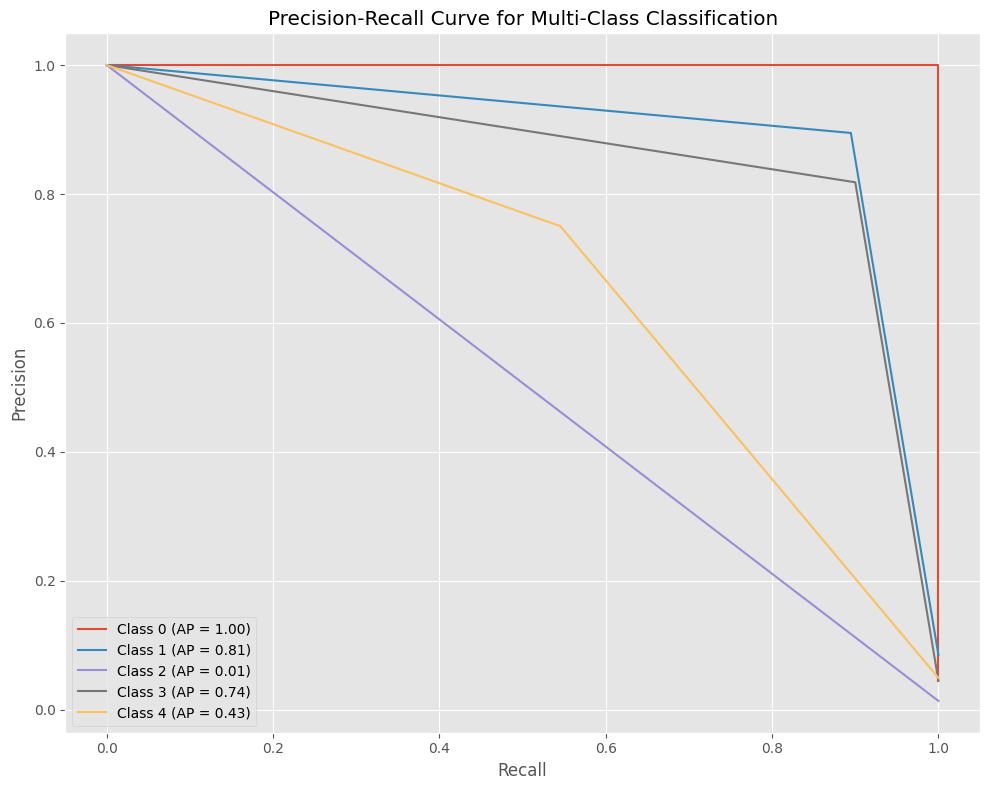

In [82]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Calculate Precision-Recall curve for each class
precisions, recalls, _ = {}, {}, {}
average_precisions = {}

for i in range(labels_bin.shape[1]):
    precisions[i], recalls[i], _ = precision_recall_curve(labels_bin[:, i], preds_bin[:, i])
    average_precisions[i] = average_precision_score(labels_bin[:, i], preds_bin[:, i])

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
for i in range(labels_bin.shape[1]):
    plt.plot(recalls[i], precisions[i], label=f'Class {i} (AP = {average_precisions[i]:.2f})')

plt.title("Precision-Recall Curve for Multi-Class Classification")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


     Actual_Category      Predicted_Category
982           OTHERS                AVIATION
943           OTHERS              HEALTHCARE
2324            ARTS                 BANKING
1630          OTHERS                    ARTS
553            LEGAL               MARKETING
2224         BANKING    BUSINESS_DEVELOPMENT
1356      AUTOMOBILE                  OTHERS
1767     ENGINEERING  INFORMATION_TECHNOLOGY
2095       MARKETING                   LEGAL
2242         BANKING              CONSULTING


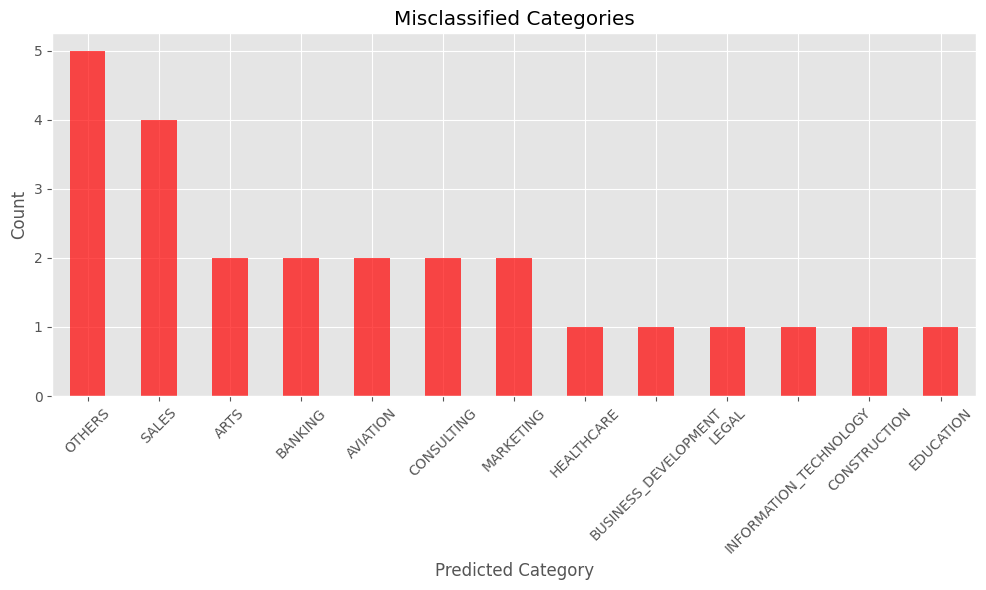

In [83]:
# Filter misclassified examples
misclassified = test_df_with_predictions[test_df_with_predictions['Predicted_Label'] != test_df_with_predictions['Actual_Label']]

# Display some of the misclassified examples
print(misclassified[['Actual_Category', 'Predicted_Category']].head(10))

# You can also visualize the misclassified examples in a bar plot
misclassified_counts = misclassified['Predicted_Category'].value_counts()

# Bar plot of misclassified predictions
plt.figure(figsize=(10, 6))
misclassified_counts.plot(kind='bar', color='red', alpha=0.7)
plt.title('Misclassified Categories')
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [84]:
model = BertForSequenceClassification.from_pretrained("/kaggle/working/Soriginal_category_model_from_combined18sss")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [85]:
def predict_resume_category(resume_text):
    inputs = tokenizer(resume_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return label_mapping[predicted_class_id]


In [86]:
def extract_text_from_pdf(pdf_path):
    from PyPDF2 import PdfReader
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# Example usage
uploaded_resume = "/kaggle/input/resume-dataset/data/data/ACCOUNTANT/10554236.pdf"  # Replace with user-uploaded file path
resume_text = extract_text_from_pdf(uploaded_resume)
predicted_category = predict_resume_category(resume_text)
print("Predicted Category:", predicted_category)


Predicted Category: ACCOUNTING


# Part 4 Starts

In [87]:
# Cell 2: Load and Prepare Dataset
# Load the dataset
data = pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")

# Intelligent Category Grouping
category_groups2 = {
    'INFORMATION-TECHNOLOGY': ['INFORMATION-TECHNOLOGY'],
    'ENGINEERING': ['ENGINEERING'],
    'AUTOMOBILE': ['AUTOMOBILE'],
    'BUSINESS-DEVELOPMENT': ['BUSINESS-DEVELOPMENT'],
    'ACCOUNTANT': ['ACCOUNTANT'],
    'FINANCE': ['FINANCE'],
    'SALES': ['SALES'],
    'BANKING': ['BANKING'],
    'CONSULTANT': ['CONSULTANT'],
    'ADVOCATE': ['ADVOCATE'],
    'CHEF': ['CHEF'],
    'FITNESS': ['FITNESS'], 
    'HEALTHCARE':['HEALTHCARE'],
    'AVIATION': ['AVIATION'],
    'PUBLIC-RELATIONS': ['PUBLIC-RELATIONS'],
    'DIGITAL-MEDIA': ['DIGITAL-MEDIA'],
    'HR': ['HR'],
    'TEACHER': ['TEACHER'],
    'DESIGNER': ['DESIGNER'],
    'CONSTRUCTION': ['CONSTRUCTION'],
    'APPAREL': ['APPAREL'],
    'AGRICULTURAL': ['AGRICULTURE'],
    'BPO': ['BPO'],
    'ARTS':['ARTS']
}

# Function to map categories
def map_to_group_category(category):
    for group, categories in category_groups2.items():
        if category in categories:
            return group
    return 'OTHERS'

# Apply category mapping
data['Grouped_Category'] = data['Category'].apply(map_to_group_category)

# Create label encoding
data['label'] = data['Grouped_Category'].astype('category').cat.codes
label_mapping = dict(enumerate(data['Grouped_Category'].astype('category').cat.categories))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'ACCOUNTANT', 1: 'ADVOCATE', 2: 'AGRICULTURAL', 3: 'APPAREL', 4: 'ARTS', 5: 'AUTOMOBILE', 6: 'AVIATION', 7: 'BANKING', 8: 'BPO', 9: 'BUSINESS-DEVELOPMENT', 10: 'CHEF', 11: 'CONSTRUCTION', 12: 'CONSULTANT', 13: 'DESIGNER', 14: 'DIGITAL-MEDIA', 15: 'ENGINEERING', 16: 'FINANCE', 17: 'FITNESS', 18: 'HEALTHCARE', 19: 'HR', 20: 'INFORMATION-TECHNOLOGY', 21: 'PUBLIC-RELATIONS', 22: 'SALES', 23: 'TEACHER'}


In [88]:
# Cell 4: Prepare Dataset
# Prepare the dataframe
df = data.drop(columns=["Resume_html", "Category"]).rename(columns={"Resume_str": "Resume"})

# Train-Test-Validation Split
train, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val, test = train_test_split(temp, test_size=0.3, stratify=temp['label'], random_state=42)
print("Train shape:", train.shape, "Validation shape:", val.shape, "Test shape:", test.shape)

Train shape: (1738, 4) Validation shape: (522, 4) Test shape: (224, 4)


In [ ]:
# Cell 4: Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Resume"], padding="max_length", truncation=True, max_length=512)

# Convert dataframes to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set dataset format
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [91]:
model = BertForSequenceClassification.from_pretrained("/kaggle/working/Soriginal_category_model_from_combined18sss")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [92]:
# Load the base BERT model with the correct number of labels
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=len(label_mapping)
)

# Load the previous model to extract its state dictionary
previous_model = BertForSequenceClassification.from_pretrained("/kaggle/working/Soriginal_category_model_from_combined18sss")

# Get the state dictionary of the previous model
state_dict = previous_model.state_dict()

# Remove classifier layers from the state dict
# This filters out the classification layer weights that don't match
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}

# Load the filtered state dict
# strict=False allows loading partial state dict
model.load_state_dict(state_dict, strict=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=[])

In [93]:
# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [94]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./Finale_category_model_from_Finale",
    evaluation_strategy="epoch",
    learning_rate=1e-5,  # Lower learning rate for fine-tuning
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Potentially fewer epochs as we're fine-tuning
    weight_decay=0.01,
    logging_dir="./logs_original_from_combined",
    logging_steps=10,
    save_total_limit=2,
    save_strategy="epoch",
)


In [95]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [96]:
# Train the model (fine-tuning)
trainer.train()

# Save the fine-tuned model
trainer.save_model("Finale_category_model_from_Finale")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.705000,1.570522,0.622605,0.619197,0.622605,0.569895
2,1.021400,1.064790,0.839080,0.834306,0.839080,0.826467
3,0.763500,0.851696,0.863985,0.852746,0.863985,0.854756
4,0.796900,0.766474,0.867816,0.861558,0.867816,0.860927
5,0.729800,0.741106,0.873563,0.866571,0.873563,0.866513


Evaluation Metrics: {'eval_loss': 0.6653578877449036, 'eval_accuracy': 0.8928571428571429, 'eval_precision': 0.8762152777777777, 'eval_recall': 0.8928571428571429, 'eval_f1': 0.8809481958826108, 'eval_runtime': 3.5262, 'eval_samples_per_second': 63.524, 'eval_steps_per_second': 3.97, 'epoch': 5.0}


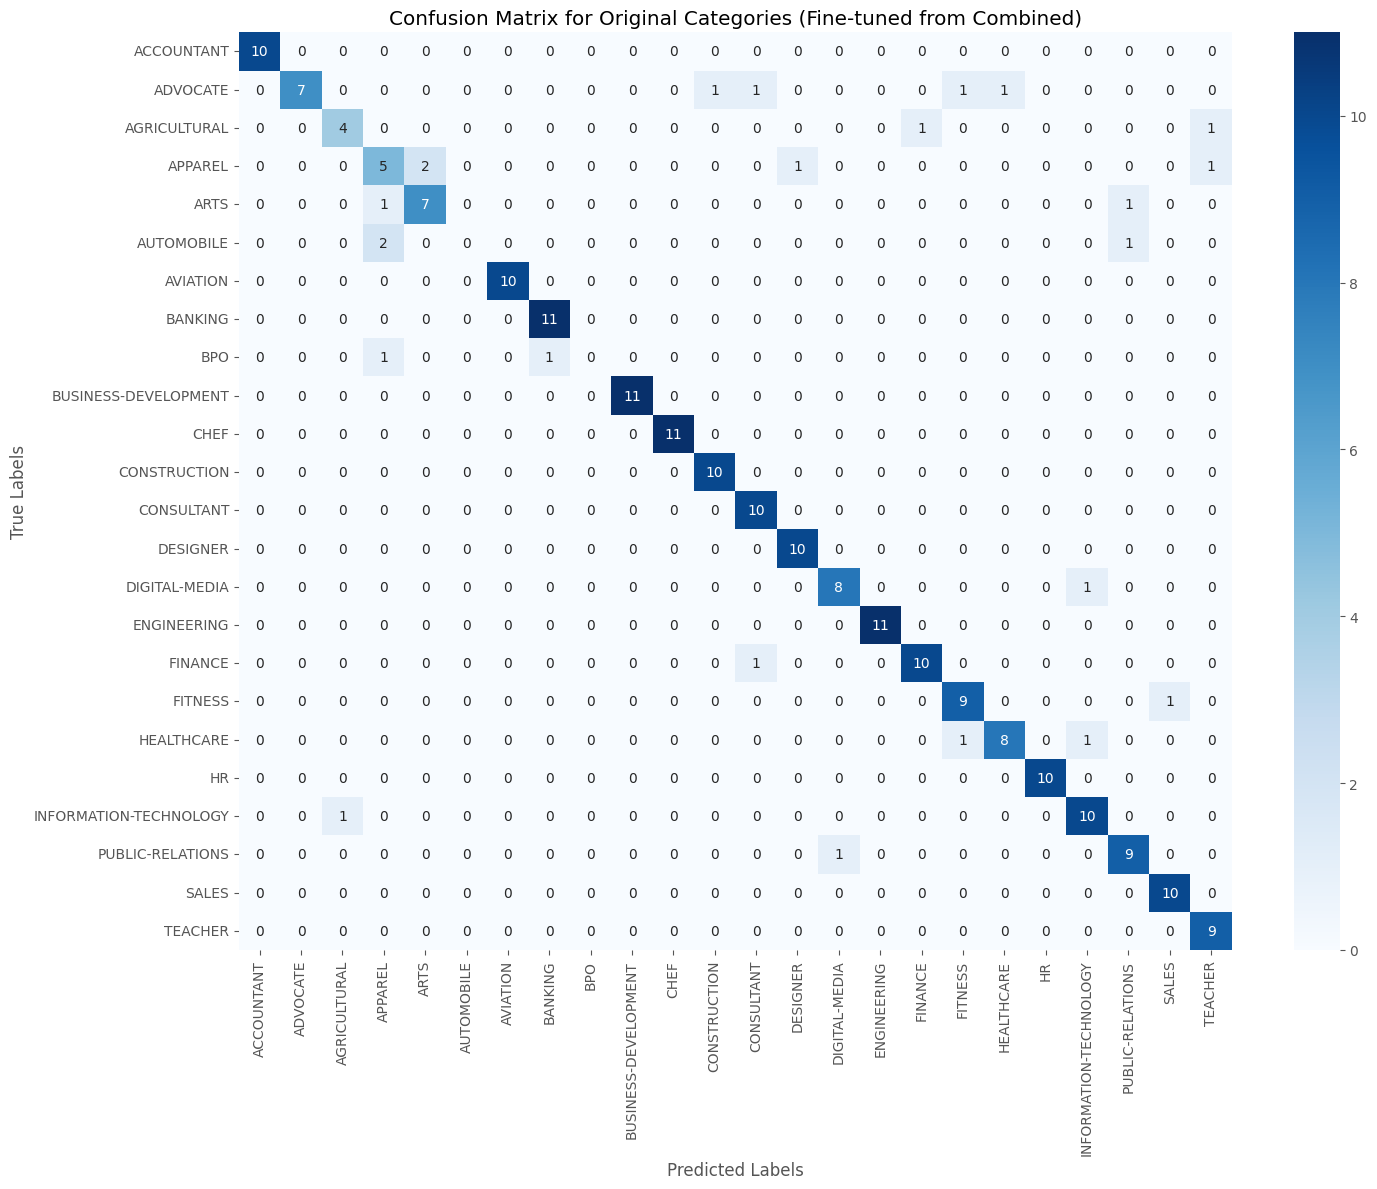

In [98]:
# Cell 6: Evaluation and Visualization
# Evaluate on test set
metrics = trainer.evaluate(test_dataset)
print("Evaluation Metrics:", metrics)

# Predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Confusion Matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_mapping.values(), 
            yticklabels=label_mapping.values())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Original Categories (Fine-tuned from Combined)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [99]:
# Cell 7: Prepare Results DataFrame
test_df_with_predictions = test.copy()
test_df_with_predictions['Predicted_Label'] = preds
test_df_with_predictions['Actual_Label'] = labels

# Map label indices to their corresponding category names
test_df_with_predictions['Predicted_Category'] = test_df_with_predictions['Predicted_Label'].map(lambda x: label_mapping.get(x))
test_df_with_predictions['Actual_Category'] = test_df_with_predictions['Actual_Label'].map(lambda x: label_mapping.get(x))

# Save the entire DataFrame with predictions
test_df_with_predictions.to_csv('/kaggle/working/original_categories_from_combined_test_predictions234454.csv', index=False)

# Display comparison of actual vs predicted
print(test_df_with_predictions[['Actual_Category', 'Predicted_Category']])

# Classification Report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=label_mapping.values()))

             Actual_Category Predicted_Category
544                 ADVOCATE         CONSULTANT
2180                 BANKING            BANKING
1302           DIGITAL-MEDIA      DIGITAL-MEDIA
324   INFORMATION-TECHNOLOGY       AGRICULTURAL
1206              CONSULTANT         CONSULTANT
...                      ...                ...
1837              ACCOUNTANT         ACCOUNTANT
442                 ADVOCATE           ADVOCATE
473                 ADVOCATE           ADVOCATE
697               HEALTHCARE         HEALTHCARE
1483                 FINANCE            FINANCE

[224 rows x 2 columns]

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       1.00      1.00      1.00        10
              ADVOCATE       1.00      0.64      0.78        11
          AGRICULTURAL       0.80      0.67      0.73         6
               APPAREL       0.56      0.56      0.56         9
                  ARTS       0.78      0.78      0.78  

In [100]:
model = BertForSequenceClassification.from_pretrained("/kaggle/working/Finale_category_model_from_Finale")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [101]:
def predict_resume_category(resume_text):
    inputs = tokenizer(resume_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return label_mapping[predicted_class_id]


In [102]:
def extract_text_from_pdf(pdf_path):
    from PyPDF2 import PdfReader
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# Example usage
uploaded_resume = "/kaggle/input/resume-dataset/data/data/AVIATION/10176815.pdf"  # Replace with user-uploaded file path
resume_text = extract_text_from_pdf(uploaded_resume)
predicted_category = predict_resume_category(resume_text)
print("Predicted Category:", predicted_category)


Predicted Category: AVIATION
